Use conda environment `conda_envs/cool.yml` to run this notebook.

In [247]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import cooler
import cooltools
from coolpuppy import coolpup
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import ticker
import seaborn as sns
import numpy as np
from scipy.stats import wilcoxon, false_discovery_control
from os import listdir, system, path
import re
import bioframe as bf
from joblib import Memory
from sklearn.cluster import KMeans
import warnings
import utils
import pickle as pkl


warnings.filterwarnings("ignore", category=FutureWarning)

# Add cache functionality to some functions
cachedir = 'cache'
memory = Memory(cachedir, verbose=0)
expected_cis_cache = memory.cache(cooltools.expected_cis, ignore=['nproc'])
expected_trans_cache = memory.cache(cooltools.expected_trans, ignore=['nproc'])
subt_snips_cache = memory.cache(utils.subt_snips, ignore=['print_ct'])

# Set color palette
palette = {
    "EN": "#6152c1", 
    "IN": "#c644a4", 
    "NN": "#ffd18c",
    '2T': "#f3ffbd", 
    '3T': "#b2dbbf",
    'infant': "#70c1b3",
    'adult': "#247ba0"
}

# Set matplotlib settings
mpl.rc('lines', linewidth=0.4)
mpl.rc('font', family='Helvetica', size=8)
mpl.rc('axes', labelsize=8, titlesize=8, linewidth=0.4)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=6)
mpl.rc('xtick.major', width=0.4, size=2)
mpl.rc('xtick.minor', width=0.4, size=1)
mpl.rc('ytick', labelsize=6)
mpl.rc('ytick.major', width=0.4, size=2)
mpl.rc('ytick.minor', width=0.4, size=1)


def plot_av_dot_pca(pup: dict, vmax: float, **subplot_kwargs):

    # get cts from pup
    grps1 = list(pup.keys())
    grps2 = list(pup[grps1[0]].keys())

    nrows, ncols = len(grps1), len(grps2)
    width_ratios = [1] * ncols
    cbar_frac = 0.2
    width_ratios.append(cbar_frac)
    vmin = 1/vmax

    subplot_kwargs.setdefault('dpi', 400)
    subplot_kwargs.setdefault('figsize', (0.2 * ncols, 0.2 * nrows))
    
    fig, axs = plt.subplots(nrows, ncols+1, gridspec_kw={'width_ratios': width_ratios}, **subplot_kwargs)
        
    for i, grp1 in enumerate(grps1):
        for j, grp2 in enumerate(grps2):
            ax = axs[i, j] if nrows > 1 else axs[j]
                
            arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
            im = ax.imshow(
                arr, 
                cmap='coolwarm',
                norm=LogNorm(vmax=vmax, vmin=vmin),
                extent=(-150000, 150000, 150000, -150000)
            )
            
            ax.yaxis.set_ticklabels([])
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])

            if i == len(grps1) - 1:
                ax.set_xlabel(grp2, fontsize=6, rotation=90, ha='center', va='top')
        
        # Colorbar
        cbar_ax = axs[i, ncols] if nrows > 1 else axs[ncols]
        plt.colorbar(im, cax=cbar_ax, ticks=[vmin, 1, vmax], 
                     format=ticker.FuncFormatter(lambda x, pos: f"{x:.2g}"))
        cbar_ax.set_box_aspect(1 / cbar_frac)
        cbar_ax.minorticks_off()

    if nrows == 1:
        axs[0].set_ylabel(grps1[0], fontsize=6, rotation=0, ha='right', va='center')
    else:
        for i, grp1 in enumerate(grps1): 
            axs[i, 0].set_ylabel(grp1, fontsize=6, rotation=0, ha='right', va='center')

    plt.subplots_adjust(hspace=0, wspace=0)

    return

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input data and parameters

In [218]:
# INPUT DATA

# Annotation of PcG contact anchors in adult neurons
hand_anch_path = "/tank/projects/polycomb/data/polycomb_dot_anchors.5kb.16_06_25.csv"

# PCA loadings
# pca_loads_path = "/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/For_paper_Nov2024start/Polycomb_Loops_PCA_Loadings.csv"
pca_loads_path = "/tank/projects/nvaulin_hic_sch/tian_polycomb_analysis/Summer2025_restart/Polycomb_Loops_PCA_Loadings_Heffel.csv"

# H3K27me3 ChIP-seq peaks and chromHMM
me3_path = {
    "IN": "/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/broadPeak/"\
          "GABA_REP1_peaks.flt.broadPeak.gz",
    "EN": "/tank/projects/schizophrenia_2021/data/kozlenkov2018/H3K27me3/broadPeak/"\
          "GLU_REP1_peaks.flt.broadPeak.gz",
    "fetal": "/tank/projects/schizophrenia_2021/data/rahman2023/fetal_ChromHMM_rgb.bed"
}

# Coolers
clr_dir = '/tank/projects/polycomb/data/heffel/mcools/'
clr_path = {
    "RG-1": "CTX.RG-1.2T.3056_cells.10kb.mcool",
    "RG-1_samp": "CTX.RG-1.2T.590_cells.10kb.mcool",
    "RG-2": "CTX.RG-2.2T.590_cells.10kb.mcool",
    "Astro_adult": "CTX.Astro.adult.559_cells.all.10kb.mcool",
    "Neu_adult_samp": "CTX.Exc_Inh.adult.590_cells.10kb.mcool",
    "Neu_2T": "CTX.Exc_Inh.2T.3056_cells.10kb.mcool",
    "Neu_3T": "CTX.Exc_Inh.3T.3056_cells.5kb.mcool",
    "Neu_infant": "CTX.Exc_Inh.infant.3056_cells.10kb.mcool",
    "Neu_adult": "CTX.Exc_Inh.adult.3056_cells.10kb.mcool",
    "EN_2T": "CTX.Exc.2T.728_cells.10kb.mcool",
    "EN_3T": "CTX.Exc.3T.728_cells.10kb.mcool",
    "EN_infant": "CTX.Exc.infant.728_cells.10kb.mcool",
    "EN_adult": "CTX.Exc.adult.728_cells.10kb.mcool",
    # "EN_2T": "CTX.Exc.2T.2176_cells.all.10kb.mcool",
    # "EN_3T": "CTX.Exc.3T.2176_cells.all.10kb.mcool",
    # "EN_infant": "CTX.Exc.infant.2176_cells.all.10kb.mcool",
    # "EN_adult": "CTX.Exc.adult.2176_cells.all.10kb.mcool",
    "IN_2T": "CTX.Inh.2T.728_cells.10kb.mcool",
    "IN_3T": "CTX.Inh.3T.728_cells.10kb.mcool",
    "IN_infant": "CTX.Inh.infant.728_cells.10kb.mcool",
    "IN_adult": "CTX.Inh.adult.728_cells.10kb.mcool",
    "EN_GW18": "CTX.Exc.2T.438_cells.20210224_GW18.10kb.mcool",
    "EN_GW20a": 'CTX.Exc.2T.749_cells.20210224_GW20a.10kb.mcool',
    'EN_GW20b': 'CTX.Exc.2T.1175_cells.20210224_GW20b.10kb.mcool',
    'EN_GW23': 'CTX.Exc.2T.467_cells.20210224_GW23.10kb.mcool',
    'EN_GW35': 'CTX.Exc.3T.1271_cells.20210316_UMB4267.10kb.mcool',
    'EN_GW39': 'CTX.Exc.3T.905_cells.20210316_UA1822.10kb.mcool',
    'EN_4mon': 'CTX.Exc.infant.1522_cells.20210316_UA1922.10kb.mcool',
    'EN_7mon': 'CTX.Exc.infant.806_cells.20191219_7mo.10kb.mcool',
    'EN_21yr': 'CTX.Exc.adult.726_cells.20210505_UMB5577.10kb.mcool',
    'EN_29yr': 'CTX.Exc.adult.1154_cells.20210505_UMB6096.10kb.mcool',
    'EN_37yr': 'CTX.Exc.adult.553_cells.20210528_UMB5621.10kb.mcool',
    "IN_GW18": "CTX.Inh.2T.170_cells.20210224_GW18.10kb.mcool",
    "IN_GW20a": 'CTX.Inh.2T.454_cells.20210224_GW20a.10kb.mcool',
    'IN_GW20b': 'CTX.Inh.2T.745_cells.20210224_GW20b.10kb.mcool',
    'IN_GW23': 'CTX.Inh.2T.625_cells.20210224_GW23.10kb.mcool',
    'IN_GW35': 'CTX.Inh.3T.363_cells.20210316_UMB4267.10kb.mcool',
    'IN_GW39': 'CTX.Inh.3T.641_cells.20210316_UA1822.10kb.mcool',
    'IN_4mon': 'CTX.Inh.infant.259_cells.20210316_UA1922.10kb.mcool',
    'IN_7mon': 'CTX.Inh.infant.469_cells.20191219_7mo.10kb.mcool',
    'IN_21yr': 'CTX.Inh.adult.472_cells.20210505_UMB5577.10kb.mcool',
    'IN_29yr': 'CTX.Inh.adult.420_cells.20210505_UMB6096.10kb.mcool',
    'IN_37yr': 'CTX.Inh.adult.205_cells.20210528_UMB5621.10kb.mcool',
}

"""
scRNA-seq data (Herring et al.)
"""
# Gene activity at PcG anchors
noex_path = "/tank/projects/schizophrenia_2021/results/2023.11.13/polycomb_dot_anchors.with_noex.csv"

# Pseudobulk counts 
pb_df_path = '/tank/projects/schizophrenia_2021/results/2023.11.13/herring_pseudobulk.csv.gz'

# Mean gene expression at 4 timepoints 
expr_dir = "/tank/projects/schizophrenia_2021/results/2023.11.13/"
heff_expr_path = {
    ct: expr_dir + f"Herring_expr_for_Heffel_stages.{ct}.log1p_CPM.csv"
    for ct in ['PN', 'IN']
}

In [40]:
# PARAMETERS

# Cooler matrix resolutions
clr_ress = [50_000, 100_000]

# Prepare data for analysis

In [41]:
# Read coolers
samps = list(clr_path.keys()) # cell types
clrs = {res: {samp: cooler.Cooler(clr_dir + clr_path[samp] + f'::resolutions/{res}') 
        for samp in samps} for res in clr_ress}

In [42]:
# Get genomic view to use with cooltools and coolpuppy
hg38_chromsizes = bf.fetch_chromsizes('hg38')
hg38_chromsizes_view = pd.DataFrame(data={'chrom': hg38_chromsizes.index, 
                                          'start': 0*len(hg38_chromsizes),
                                          'end': hg38_chromsizes.values,
                                          'name': hg38_chromsizes.index})
# Drop chrX, chrY, chrM
hg38_chromsizes_view = hg38_chromsizes_view\
    .loc[~hg38_chromsizes_view['name'].isin(['chrX', 'chrY', 'chrM'])]

In [43]:
# Load PcG contact annotation from adult neurons
hand_anch = pd.read_csv(hand_anch_path)
hand_anch = bf.sort_bedframe(hand_anch, hg38_chromsizes_view)

# If no gene overlaps anchor, assign unique index
n_nan = sum(hand_anch['genes'].isna())
hand_anch.loc[hand_anch['genes'].isna(), 'genes'] = [f"locus_{i}" for i in range(n_nan)]

# If anchors appear within 'res' from each other, merge anchors into one
hand_anch_d = {}
for res in clr_ress:
    hand_anch_d[res] = hand_anch.copy()
    hand_anch_d[res].loc[:, 'mid_start'] = (hand_anch_d[res]['start'] + hand_anch_d[res]['end']) / 2 \
        - ((hand_anch_d[res]['start'] + hand_anch_d[res]['end']) / 2) % res
    hand_anch_d[res].loc[:, 'mid_end'] = hand_anch_d[res]['mid_start'] + res
    hand_anch_d[res].loc[:, 'mid_start'] = hand_anch_d[res].loc[:, 'mid_start'].astype(int)
    hand_anch_d[res].loc[:, 'mid_end'] = hand_anch_d[res].loc[:, 'mid_end'].astype(int)
    
    
    hand_anch_d[res] = hand_anch_d[res].drop(columns=['start', 'end'])\
        .groupby(['chrom', 'mid_start', 'mid_end'], as_index=False)\
        .agg({'genes': lambda x: ','.join(x)})\
        .reset_index(drop=True)\
        .rename(columns={'mid_start': 'start', 'mid_end': 'end'})\
        .loc[:, ['chrom', 'start', 'end', 'genes']]
    hand_anch_d[res][['start', 'end']] = hand_anch_d[res][['start', 'end']].astype(int)

hand_anch_d[clr_ress[0]].head()

chrom     start       end            genes
0  chr1  18600000  18650000             PAX7
1  chr1  24900000  24950000            RUNX3
2  chr1  44400000  44450000           RNF220
3  chr1  46450000  46500000          locus_0
4  chr1  47200000  47250000  TAL1,AL135960.1

In [44]:
# Extract gene names at PcG anchors
hand_genes_all = hand_anch['genes'].dropna().str.split(',').values
hand_genes_all = [item for sublist in hand_genes_all for item in sublist]

# remove transcripts and ncRNAs
regex = re.compile(r'(^LINC|^RNA|^MIR|^A[LCP][0-9]+|.*\-AS|.*\-DT|.*\-OT)')
hand_pc = [i for i in hand_genes_all if not regex.match(i)]
hand_pc[:5]

['PAX7', 'RUNX3', 'RNF220', 'locus_0', 'TAL1']

In [45]:
# Separate anchors into two groups, active (noex=False) and inactive (noex=True), 
# based on expression of genes at the anchors
noex = pd.read_csv(noex_path, na_values='no_gene')

# Take into account that anchors within the same resolution bin are merged
# and assign noex value correctly
for res in clr_ress:
    hand_anch_d[res] = bf.overlap(hand_anch_d[res], noex, how='inner')\
        .groupby(['chrom', 'start', 'end', 'genes'], as_index=False)['noex_']\
        .all()\
        .rename(columns={'noex_': 'noex'})
hand_anch_d[clr_ress[0]].head()

chrom     start       end            genes   noex
0  chr1  18600000  18650000             PAX7  False
1  chr1  24900000  24950000            RUNX3   True
2  chr1  44400000  44450000           RNF220  False
3  chr1  46450000  46500000          locus_0   True
4  chr1  47200000  47250000  TAL1,AL135960.1   True

# Plot: example region from 5 Hi-C maps of neuronal development

In [46]:
res = 100_000
pl_clrs = {
    "RG-1": clrs[res]["RG-1"],
    "2T": clrs[res]['Neu_2T'],
    "3T": clrs[res]['Neu_3T'],
    "infant": clrs[res]['Neu_infant'],
    "adult": clrs[res]['Neu_adult'],
}
pl_grps = list(pl_clrs.keys())

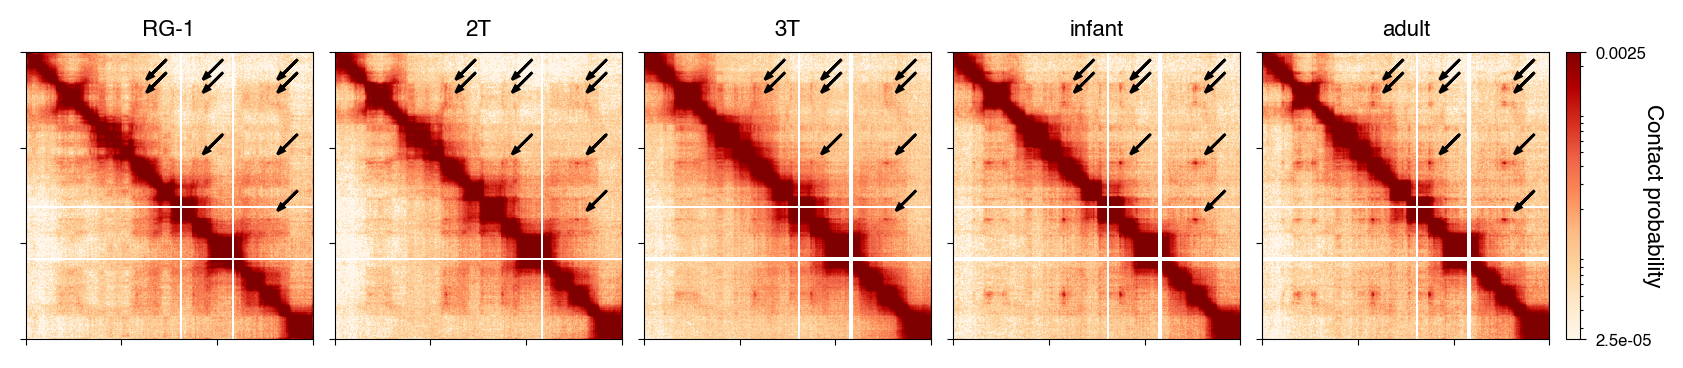

In [47]:
# Draw heatmaps
plot_reg = ('chr1', 40_000_000, 100_000_000)
vmin, vmax = 0.000025, 0.0025 # 100kb res
wr = [1] * len(pl_grps)
wr.append(0.05)
regs2annot = [[63_320_000, 47_710_000],
              [63_320_000, 50_430_000],
              [75_120_000, 47_710_000],
              [75_120_000, 50_430_000],
              [75_120_000, 63_320_000],
              [90_720_000, 47_710_000],
              [90_720_000, 50_430_000],
              [90_720_000, 63_320_000],
              [90_720_000, 75_120_000]]
arr_offset = 3_000_000
f, axs = plt.subplots(1, len(pl_grps) + 1, dpi=200, figsize=(8.3, 4), 
                      constrained_layout=True, width_ratios=wr)

for i, grp in enumerate(pl_grps):
    ax = axs[i]
    im = utils.plot_hic_reg_zoom_out(
        pl_clrs[grp], 
        reg=plot_reg, 
        ax=ax, 
        vmin=vmin, 
        vmax=vmax, 
        title=grp,
        cbar=False,
        cmap='OrRd'
    )
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for reg in regs2annot:
        ax.arrow(reg[0] + 2*arr_offset, reg[1] - 2*arr_offset, 
                 -arr_offset, arr_offset, width=1e4, head_width=1e6, fc='k')

# Draw colorbar
ax = axs[len(pl_grps)]
cb = plt.colorbar(im, cax=ax, 
             ticks=[vmin, vmax], 
             orientation='vertical',
             format=ticker.FuncFormatter(lambda x, pos: f"{x:.2g}"))
cb.ax.set_ylabel('Contact probability', rotation=270, fontsize=8)
ax.set_box_aspect(20)

# plt.savefig("heffel_5maps_neur_dev.pdf")

# Average dots and boxplots

Average dots & boxplots (by window = True):

- EN-IN at 4 stages (same number of cells) - 50kb
- EN-IN by samples - 50 kb

Average dots:

- RG1-RG2-adult astrocytes-adult_neurons - 50kb
- neuronal RG and all neurons at 4 stages and at 3 distance ranges - 50kb
- neuronal RG and all neurons at 4 stages divided into "silent" and "active" - 50kb

## Plot: EN-IN at 4 stages

Average dot & boxplots

In [151]:
# Select required coolers
res = 50_000
pl_clrs = {
    'EN': {
        "2T": clrs[res]['EN_2T'],
        "3T": clrs[res]['EN_3T'],
        "infant": clrs[res]['EN_infant'],
        "adult": clrs[res]['EN_adult'],
    },
    'IN': {
        "2T": clrs[res]['IN_2T'],
        "3T": clrs[res]['IN_3T'],
        "infant": clrs[res]['IN_infant'],
        "adult": clrs[res]['IN_adult'],
    },
}
pl_cts, pl_ages = ['EN', 'IN'], ['2T', '3T', 'infant', 'adult']

In [152]:
# Expected
pl_cvd = {ct: {} for ct in pl_cts}
nproc = 10
for ct in pl_cts:
    for age in pl_ages:
        print(ct, age)
        pl_cvd[ct][age] = expected_cis_cache(
            pl_clrs[ct][age],
            view_df=hg38_chromsizes_view,
            smooth=True,
            nproc=nproc
        )

EN 2T
EN 3T
EN infant
EN adult
IN 2T
IN 3T
IN infant
IN adult


In [153]:
# Pileup
by_window = True
features = hand_anch_d[res]
nproc=15

# Split by distance
pl_pups = {ct: {} for ct in pl_cts}
for ct in pl_cts:
    for age in pl_ages:
        print(ct, age)
        pl_pups[ct][age] = coolpup.pileup(
            pl_clrs[ct][age],
            features,
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[ct][age],
            flank=15 * res,
            mindist=int(3e6),
            by_window=by_window,
            nproc=nproc
        );

EN 2T


INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:Total number of piled up windows: 3826


EN 3T


INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:Total number of piled up windows: 3826


EN infant


INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:Total number of piled up windows: 3826


EN adult


INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:Total number of piled up windows: 3826


IN 2T


INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:Total number of piled up windows: 3826


IN 3T


INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:Total number of piled up windows: 3826


IN infant


INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:Total number of piled up windows: 3826


IN adult


INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:Total number of piled up windows: 3826


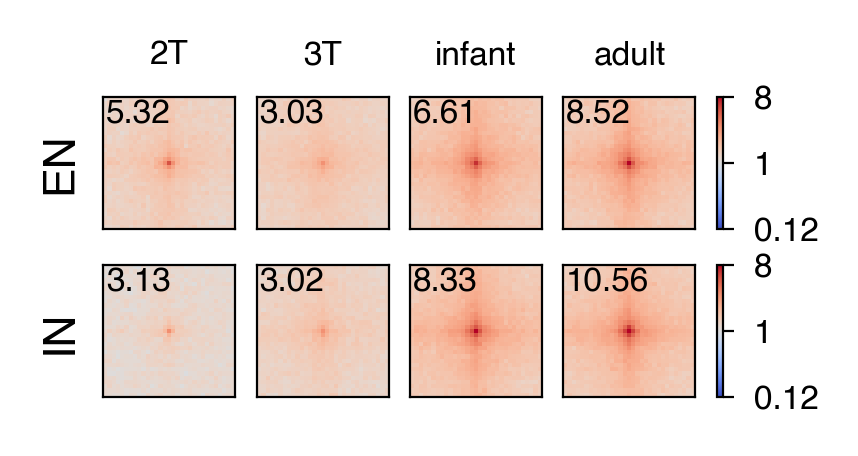

In [159]:
utils.plot_av_dot_2d(pl_pups, 8, figsize=[2, 1])
# plt.savefig("average_dot_intensity_EN_IN.pdf", bbox_inches='tight')

In [122]:
# Prepare dataframe for boxplots
n_dots = pl_pups[pl_cts[0]][pl_ages[0]].shape[0]
n_cts, n_ages = len(pl_cts), len(pl_ages)
cent_vals = np.empty((n_dots, n_cts * n_ages), dtype=float)

j=0
for ct in pl_cts:
    for age in pl_ages:
        arr = pl_pups[ct][age]['data'].to_list()
        for i, snip in enumerate(arr):
            cent_vals[i, j] = snip[snip.shape[0] // 2, snip.shape[1] // 2]
        j+=1

pup_df_cols = pd.MultiIndex.from_product([pl_cts, pl_ages], names=['ct', 'age'])
pup_df = pd.DataFrame(data=cent_vals, columns=pup_df_cols).dropna()
pup_df.head()

ct         EN                                      IN                      \
age        2T        3T    infant     adult        2T        3T    infant   
0    0.944585  0.775998  5.885173  5.962052  1.124851  3.324341  4.261292   
1    1.692865  2.662337  6.354172  4.775383  2.549640  2.328809  4.913351   
2    1.283601  2.309306  3.974541  4.269895  2.932117  0.737472  4.501845   
3    3.769308  1.239129  2.914154  2.912145  4.234630  6.716082  3.087669   
4    5.842031  4.682788  7.657746  8.185305  5.508197  2.822235  8.600401   

ct             
age     adult  
0    7.736056  
1    8.104812  
2    4.120984  
3    6.334795  
4    8.590916

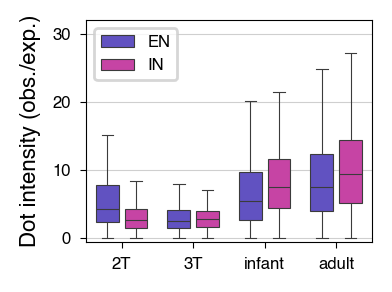

In [150]:
# Boxplots
plt.figure(dpi=200, figsize=[2, 1.5])
plot_df = pup_df.melt()
sns.boxplot(data=plot_df, 
            x='age', 
            y='value', 
            hue='ct', 
            showfliers=False, 
            linewidth=0.4, 
            gap=0.2,
            palette=palette,
            saturation=1, 
           )
plt.ylabel('Dot intensity (obs./exp.)')
plt.xlabel('')
plt.ylim([-0.5, 32])
plt.legend(fontsize=6)
plt.grid(axis='y', alpha=0.6, linewidth=0.4)
plt.tight_layout()
# plt.savefig("boxplot_dot_instensity_EN_IN.pdf")

In [143]:
# Calculate significance for boxplots
for age in ['2T', '3T', 'infant', 'adult']:
    print(
        age, wilcoxon(pup_df[('EN', age)], pup_df[('IN', age)]).pvalue, '\n',
    )
print(wilcoxon(pup_df[('EN', '3T')], pup_df[('EN', 'infant')]).pvalue, '\n',)

2T 6.44583374120539e-22 

3T 0.6668370830780469 

infant 2.431567780642166e-13 

adult 5.758919343583535e-11 

4.3612557984972097e-35 



## Plot: EN-IN by samples

In [160]:
# Select required coolers
res = 50_000
pl_clrs = {
    'EN': {
        "GW18": clrs[res]['EN_GW18'],
        "GW20a": clrs[res]['EN_GW20a'],
        "GW20b": clrs[res]['EN_GW20b'],
        "GW23": clrs[res]['EN_GW23'],
        "GW35": clrs[res]['EN_GW35'],
        "GW39": clrs[res]['EN_GW39'],
        "4mon": clrs[res]['EN_4mon'],
        "7mon": clrs[res]['EN_7mon'],
        "21yr": clrs[res]['EN_21yr'],
        "29yr": clrs[res]['EN_29yr'],
        "37yr": clrs[res]['EN_37yr'],
    },
    'IN': {
        "GW18": clrs[res]['IN_GW18'],
        "GW20a": clrs[res]['IN_GW20a'],
        "GW20b": clrs[res]['IN_GW20b'],
        "GW23": clrs[res]['IN_GW23'],
        "GW35": clrs[res]['IN_GW35'],
        "GW39": clrs[res]['IN_GW39'],
        "4mon": clrs[res]['IN_4mon'],
        "7mon": clrs[res]['IN_7mon'],
        "21yr": clrs[res]['IN_21yr'],
        "29yr": clrs[res]['IN_29yr'],
        "37yr": clrs[res]['IN_37yr'],
    },
}
pl_grps1 = list(pl_clrs.keys())
pl_grps2 = list(pl_clrs[pl_grps1[0]].keys())

In [161]:
# Expected
warnings.filterwarnings("ignore", category=FutureWarning)


pl_cvd = {grp1: {} for grp1 in pl_grps1}
nproc = 10
for grp1 in pl_grps1:
    for grp2 in pl_grps2:
        print(grp1, grp2)
        pl_cvd[grp1][grp2] = expected_cis_cache(
            pl_clrs[grp1][grp2],
            view_df=hg38_chromsizes_view,
            smooth=True,
            nproc=nproc
        )

EN GW18
EN GW20a
EN GW20b
EN GW23
EN GW35
EN GW39
EN 4mon
EN 7mon
EN 21yr
EN 29yr
EN 37yr
IN GW18
IN GW20a
IN GW20b
IN GW23
IN GW35
IN GW39
IN 4mon
IN 7mon
IN 21yr
IN 29yr
IN 37yr


In [162]:
# Pileup
by_window = True
features = hand_anch_d[res]
nproc=15

# Split by distance
pl_pups = {grp1: {} for grp1 in pl_grps1}
for grp1 in pl_grps1:
    for grp2 in pl_grps2:
        print(grp1, grp2)
        pl_pups[grp1][grp2] = coolpup.pileup(
            pl_clrs[grp1][grp2],
            features,
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[grp1][grp2],
            flank=15 * res,
            mindist=int(3e6),
            by_window=by_window,
            nproc=nproc
        );

EN GW18


INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:Total number of piled up windows: 3826


EN GW20a


INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:Total number of piled up windows: 3826


EN GW20b


INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:Total number of piled up windows: 3826


EN GW23


INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:Total number of piled up windows: 3826


EN GW35


INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:Total number of piled up windows: 3826


EN GW39


INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:Total number of piled up windows: 3826


EN 4mon


INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:Total number of piled up windows: 3826


EN 7mon


INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:Total number of piled up windows: 3826


EN 21yr


INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:Total number of piled up windows: 3826


EN 29yr


INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:Total number of piled up windows: 3826


EN 37yr


INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:Total number of piled up windows: 3826


IN GW18


INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:Total number of piled up windows: 3826


IN GW20a


INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:Total number of piled up windows: 3826


IN GW20b


INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:Total number of piled up windows: 3826


IN GW23


INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:Total number of piled up windows: 3826


IN GW35


INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:Total number of piled up windows: 3826


IN GW39


INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:Total number of piled up windows: 3826


IN 4mon


INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:Total number of piled up windows: 3826


IN 7mon


INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:Total number of piled up windows: 3826


IN 21yr


INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:Total number of piled up windows: 3826


IN 29yr


INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:Total number of piled up windows: 3826


IN 37yr


INFO:coolpuppy:('chr9', 'chr9'): 148
INFO:coolpuppy:('chr3', 'chr3'): 86
INFO:coolpuppy:('chr15', 'chr15'): 40
INFO:coolpuppy:('chr10', 'chr10'): 220
INFO:coolpuppy:('chr11', 'chr11'): 98
INFO:coolpuppy:('chr14', 'chr14'): 44
INFO:coolpuppy:('chr7', 'chr7'): 220
INFO:coolpuppy:('chr5', 'chr5'): 514
INFO:coolpuppy:('chr1', 'chr1'): 434
INFO:coolpuppy:('chr13', 'chr13'): 96
INFO:coolpuppy:('chr4', 'chr4'): 290
INFO:coolpuppy:('chr8', 'chr8'): 102
INFO:coolpuppy:('chr6', 'chr6'): 520
INFO:coolpuppy:('chr12', 'chr12'): 44
INFO:coolpuppy:('chr2', 'chr2'): 826
INFO:coolpuppy:('chr16', 'chr16'): 36
INFO:coolpuppy:('chr17', 'chr17'): 64
INFO:coolpuppy:('chr20', 'chr20'): 8
INFO:coolpuppy:('chr18', 'chr18'): 34
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:Total number of piled up windows: 3826


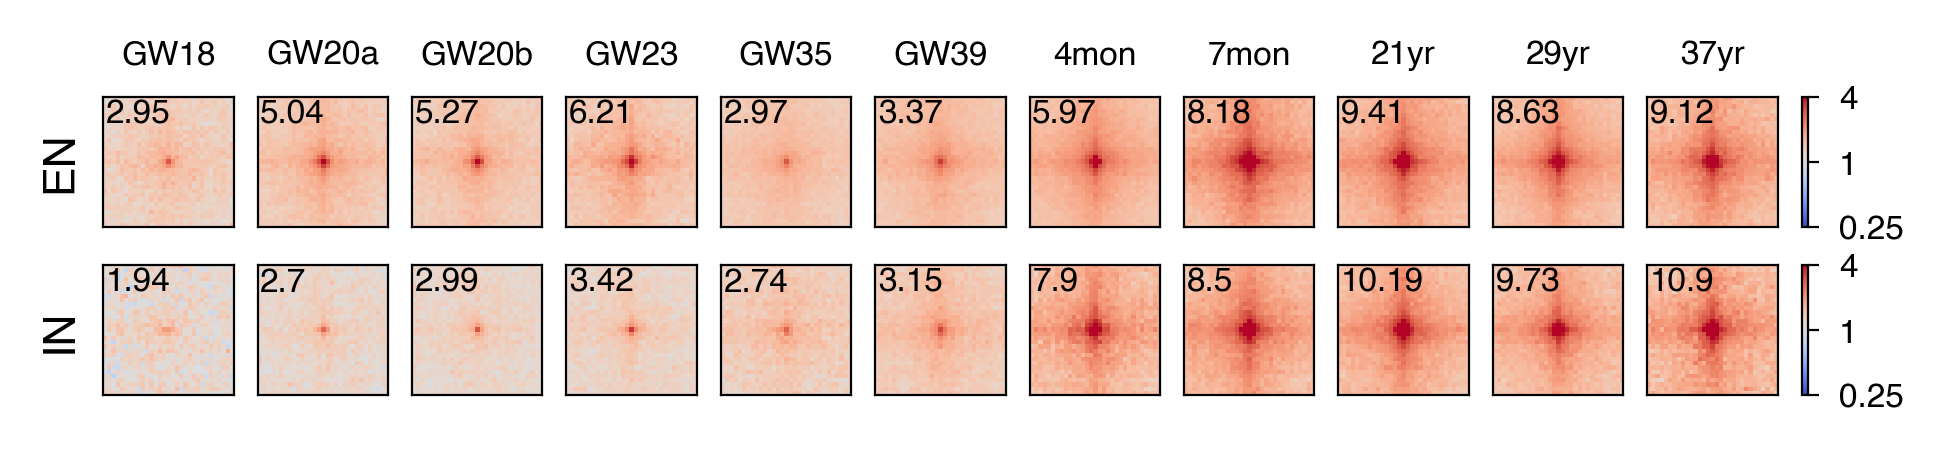

In [163]:
utils.plot_av_dot_2d(pl_pups, 4)

In [164]:
# Prepare dataframe for boxplots
n_dots = pl_pups[pl_grps1[0]][pl_grps2[0]].shape[0]
n_grps1, n_grps2 = len(pl_grps1), len(pl_grps2)
cent_vals = np.empty((n_dots, n_grps1 * n_grps2), dtype=float)

j=0
for grp1 in pl_grps1:
    for grp2 in pl_grps2:
        arr = pl_pups[grp1][grp2]['data'].to_list()
        for i, snip in enumerate(arr):
            cent_vals[i, j] = snip[snip.shape[0] // 2, snip.shape[1] // 2]
        j+=1

pup_df_cols = pd.MultiIndex.from_product([pl_grps1, pl_grps2], names=['ct', 'age'])
pup_df = pd.DataFrame(data=cent_vals, columns=pup_df_cols).dropna()
pup_df.head()

ct         EN                                                              \
age      GW18     GW20a     GW20b      GW23      GW35      GW39      4mon   
0    1.533094  1.443702  1.143096  1.199106  1.075589  1.462927  2.629860   
1    2.156343  1.576523  1.678469  1.083892  2.556284  2.873353  6.478592   
2    0.289812  1.188568  2.067061  3.878127  2.615703  2.705141  1.976561   
3    4.839326  3.291558  3.958070  3.745503  3.038233  2.118772  3.263338   
4    6.903361  8.356741  4.816295  9.702291  3.314352  4.805679  6.076169   

ct                                 ...        IN                      \
age      7mon      21yr      29yr  ...     GW20a     GW20b      GW23   
0    9.754050  6.121197  6.421572  ...  5.015988  1.691573  1.511059   
1    7.304382  5.061341  3.406715  ...  0.662781  1.675595  4.246736   
2    5.866253  6.073459  4.869012  ...  2.284357  1.041603  2.801367   
3    3.438180  2.564958  2.884778  ...  1.932660  3.310452  2.212086   
4    8.183018  6.453157  7.067615  ...  3.938486  3.807467  6.795980   

ct                                                                           
age      GW35      GW39      4mon      7mon       21yr       29yr      37yr  
0    2.357363  3.744467  4.299680  4.297089  10.602776  10.423052  4.761659  
1    2.565381  1.143344  5.608002  4.461821  14.537153   7.398909  3.868710  
2    1.268540  1.326916  3.860900  4.892738   6.329850   6.847964  4.762908  
3    5.532443  6.520153  2.637212  3.399002   6.046732   3.658054  5.583370  
4    2.314127  3.273777  7.330459  9.893965  11.403875   8.519462  9.554905  

[5 rows x 22 columns]

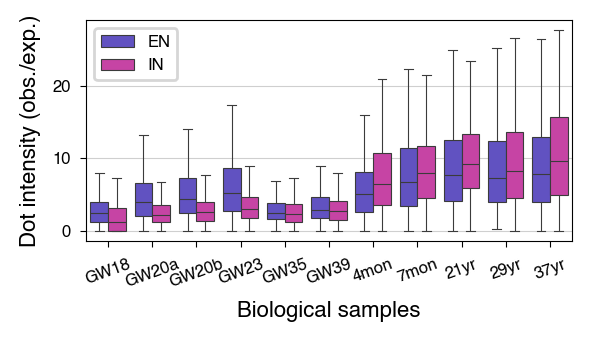

In [166]:
# Boxplots
plt.figure(dpi=200, figsize=[3, 1.75])
plot_df = pup_df.melt()
sns.boxplot(data=plot_df, 
            x='age', 
            y='value', 
            hue='ct', 
            showfliers=False, 
            linewidth=0.4, 
            palette=palette,
            saturation=1, 
           )
plt.ylabel('Dot intensity (obs./exp.)')
plt.xlabel('Biological samples')
plt.xticks(rotation=20)
plt.legend(fontsize=6)
plt.grid(axis='y', alpha=0.6, linewidth=0.4)
plt.tight_layout()
# plt.savefig("boxplot_dot_instensity_EN_IN_reps.pdf")

In [167]:
# Calculate significance for boxplots
pvals = []
for grp in pl_grps2:
    p = wilcoxon(pup_df[('EN', grp)], pup_df[('IN', grp)]).pvalue
    pvals.append(p)

for grp in pl_grps1:
    p = wilcoxon(pup_df[(grp, 'GW18')], pup_df[(grp, 'GW35')]).pvalue
    pvals.append(p)
    p = wilcoxon(pup_df[(grp, 'GW20a')], pup_df[(grp, 'GW35')]).pvalue
    pvals.append(p)
    p = wilcoxon(pup_df[(grp, 'GW39')], pup_df[(grp, '4mon')]).pvalue
    pvals.append(p)

# FDR correction
padj = false_discovery_control(pvals)
padj

array([3.48026036e-09, 5.49778314e-23, 2.37462184e-22, 2.05635253e-24,
       3.74596716e-02, 8.72768368e-02, 1.67636099e-14, 1.26898716e-01,
       7.38218153e-04, 1.15173581e-04, 6.74490424e-06, 5.80055058e-01,
       1.47875104e-22, 2.62247525e-32, 1.54693817e-07, 9.33467867e-01,
       1.17433028e-36])

## Plot: RG1-RG2-adult astrocytes-adult_neurons

In [168]:
# Select required coolers
res = 50_000
pl_clrs = {
    'Neu': {
        "RG": clrs[res]["RG-1_samp"],
        "adult": clrs[res]['Neu_adult_samp'],
    },
    'Astro': {
        "RG": clrs[res]['RG-2'],
        "adult": clrs[res]['Astro_adult'],
    },
}
pl_cts, pl_ages = ['Neu', 'Astro'], ['RG', 'adult']

In [169]:
# Expected
warnings.filterwarnings("ignore", category=FutureWarning)


pl_cvd = {ct: {} for ct in pl_cts}
nproc = 10
for ct in pl_cts:
    for age in pl_ages:
        print(ct, age)
        pl_cvd[ct][age] = expected_cis_cache(
            pl_clrs[ct][age],
            view_df=hg38_chromsizes_view,
            smooth=False,
            nproc=nproc
        )

Neu RG
Neu adult
Astro RG
Astro adult


In [170]:
# Pileup
by_window = False
features = hand_anch_d[res]
nproc=15

# Split by distance
pl_pups = {ct: {} for ct in pl_cts}
for ct in pl_cts:
    for age in pl_ages:
        print(ct, age)
        pl_pups[ct][age] = coolpup.pileup(
            pl_clrs[ct][age],
            features,
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[ct][age],
            flank=15 * res,
            mindist=int(3e6),
            by_window=by_window,
            nproc=nproc
        );

Neu RG


INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr9', 'chr9'): 74
INFO:coolpuppy:('chr8', 'chr8'): 51
INFO:coolpuppy:('chr6', 'chr6'): 260
INFO:coolpuppy:('chr11', 'chr11'): 49
INFO:coolpuppy:('chr5', 'chr5'): 257
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr3', 'chr3'): 43
INFO:coolpuppy:('chr4', 'chr4'): 145
INFO:coolpuppy:('chr10', 'chr10'): 110
INFO:coolpuppy:('chr7', 'chr7'): 110
INFO:coolpuppy:('chr2', 'chr2'): 413
INFO:coolpuppy:('chr1', 'chr1'): 217
INFO:coolpuppy:('chr18', 'chr18'): 17
INFO:coolpuppy:('chr21', 'chr21'): 1
INFO:coolpuppy:('chr20', 'chr20'): 4
INFO:coolpuppy:('chr17', 'chr17'): 32
INFO:coolpuppy:('chr16', 'chr16'): 18
INFO:coolpuppy:Total number of piled up windows: 1913


Neu adult


INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr9', 'chr9'): 74
INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr7', 'chr7'): 110
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr5', 'chr5'): 257
INFO:coolpuppy:('chr4', 'chr4'): 145
INFO:coolpuppy:('chr11', 'chr11'): 49
INFO:coolpuppy:('chr10', 'chr10'): 110
INFO:coolpuppy:('chr8', 'chr8'): 51
INFO:coolpuppy:('chr6', 'chr6'): 260
INFO:coolpuppy:('chr2', 'chr2'): 413
INFO:coolpuppy:('chr1', 'chr1'): 217
INFO:coolpuppy:('chr3', 'chr3'): 43
INFO:coolpuppy:('chr16', 'chr16'): 18
INFO:coolpuppy:('chr17', 'chr17'): 32
INFO:coolpuppy:('chr18', 'chr18'): 17
INFO:coolpuppy:('chr21', 'chr21'): 1
INFO:coolpuppy:('chr20', 'chr20'): 4
INFO:coolpuppy:Total number of piled up windows: 1913


Astro RG


INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr10', 'chr10'): 110
INFO:coolpuppy:('chr8', 'chr8'): 51
INFO:coolpuppy:('chr7', 'chr7'): 110
INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr3', 'chr3'): 43
INFO:coolpuppy:('chr4', 'chr4'): 145
INFO:coolpuppy:('chr9', 'chr9'): 74
INFO:coolpuppy:('chr11', 'chr11'): 49
INFO:coolpuppy:('chr6', 'chr6'): 260
INFO:coolpuppy:('chr5', 'chr5'): 257
INFO:coolpuppy:('chr2', 'chr2'): 413
INFO:coolpuppy:('chr1', 'chr1'): 217
INFO:coolpuppy:('chr16', 'chr16'): 18
INFO:coolpuppy:('chr18', 'chr18'): 17
INFO:coolpuppy:('chr21', 'chr21'): 1
INFO:coolpuppy:('chr20', 'chr20'): 4
INFO:coolpuppy:('chr17', 'chr17'): 32
INFO:coolpuppy:Total number of piled up windows: 1913


Astro adult


INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr9', 'chr9'): 74
INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr8', 'chr8'): 51
INFO:coolpuppy:('chr7', 'chr7'): 110
INFO:coolpuppy:('chr4', 'chr4'): 145
INFO:coolpuppy:('chr5', 'chr5'): 257
INFO:coolpuppy:('chr6', 'chr6'): 260
INFO:coolpuppy:('chr11', 'chr11'): 49
INFO:coolpuppy:('chr1', 'chr1'): 217
INFO:coolpuppy:('chr10', 'chr10'): 110
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr3', 'chr3'): 43
INFO:coolpuppy:('chr17', 'chr17'): 32
INFO:coolpuppy:('chr18', 'chr18'): 17
INFO:coolpuppy:('chr21', 'chr21'): 1
INFO:coolpuppy:('chr16', 'chr16'): 18
INFO:coolpuppy:('chr20', 'chr20'): 4
INFO:coolpuppy:('chr2', 'chr2'): 413
INFO:coolpuppy:Total number of piled up windows: 1913


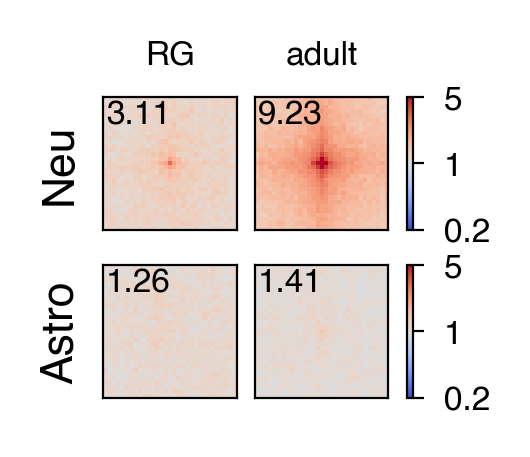

In [172]:
utils.plot_av_dot_2d(pl_pups, 5)
# plt.savefig("average_dot_intensity_RG.pdf", bbox_inches='tight')

## Plot: neuronal RG and all neurons at 4 stages and at 3 distance ranges

In [173]:
# Select required coolers
res = 50_000
pl_clrs = {
    "RG-1": clrs[res]["RG-1"],
    "2T": clrs[res]['Neu_2T'],
    "3T": clrs[res]['Neu_3T'],
    "infant": clrs[res]['Neu_infant'],
    "adult": clrs[res]['Neu_adult'],
}
pl_grps = list(pl_clrs.keys())

In [174]:
# Expected
# cis
pl_cvd = {}
nproc = 10
for grp in pl_grps:
    print("cis", grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

# trans
pl_cvd_trans = {}
for grp in pl_grps:
    print("trans", grp)
    pl_cvd_trans[grp] = expected_trans_cache(
        pl_clrs[grp],
        nproc=nproc
    )

cis RG-1
cis 2T
cis 3T
cis infant
cis adult
trans RG-1
trans 2T
trans 3T
trans infant
trans adult


In [179]:
# Pileup
by_window = False
features = hand_anch_d[res]
nproc=15

# Split by distance
pl_pups = {'short': {}, 'long': {}, 'trans': {}}
for grp in pl_grps:
    print(grp)
    pl_pups['short'][grp] = coolpup.pileup(
        pl_clrs[grp],
        features,
        view_df=hg38_chromsizes_view,
        expected_df=pl_cvd[grp],
        flank=15 * res,
        mindist=3*res,
        maxdist=int(3e6),
        by_window=by_window,
        nproc=nproc
    );
    pl_pups['long'][grp] = coolpup.pileup(
        pl_clrs[grp],
        features,
        view_df=hg38_chromsizes_view,
        expected_df=pl_cvd[grp],
        flank=15 * res,
        mindist=int(3e6),
        by_window=by_window,
        nproc=nproc
    );
    pl_pups['trans'][grp] = coolpup.pileup(
        pl_clrs[grp],
        features,
        expected_df=pl_cvd_trans[grp],
        flank=15 * res,
        trans=True,
        by_window=by_window,
        nproc=nproc
    );

RG-1


INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr13', 'chr13'): 7
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr12', 'chr12'): 6
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr8', 'chr8'): 3
INFO:coolpuppy:('chr7', 'chr7'): 9
INFO:coolpuppy:('chr6', 'chr6'): 14
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr5', 'chr5'): 14
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 6
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chr18', 'chr18'): 4
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 15
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:Total number of piled up windows: 138
INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr9', 'chr9'): 74
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr11', 'chr11')

2T


INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr13', 'chr13'): 7
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr12', 'chr12'): 6
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr8', 'chr8'): 3
INFO:coolpuppy:('chr7', 'chr7'): 9
INFO:coolpuppy:('chr6', 'chr6'): 14
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr18', 'chr18'): 4
INFO:coolpuppy:('chr5', 'chr5'): 14
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chr20', 'chr20'): 6
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 15
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:Total number of piled up windows: 138
INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr9', 'chr9'): 74
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr11', 'chr11')

3T


INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr13', 'chr13'): 7
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr12', 'chr12'): 6
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr8', 'chr8'): 3
INFO:coolpuppy:('chr7', 'chr7'): 9
INFO:coolpuppy:('chr6', 'chr6'): 14
INFO:coolpuppy:('chr18', 'chr18'): 4
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr20', 'chr20'): 6
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr5', 'chr5'): 14
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 15
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:Total number of piled up windows: 138
INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr9', 'chr9'): 74
INFO:coolpuppy:('chr11', 'chr11'): 49
INFO:coolpuppy:('chr12', 'chr12')

infant


INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr13', 'chr13'): 7
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr12', 'chr12'): 6
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr8', 'chr8'): 3
INFO:coolpuppy:('chr7', 'chr7'): 9
INFO:coolpuppy:('chr6', 'chr6'): 14
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr5', 'chr5'): 14
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr18', 'chr18'): 4
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chr20', 'chr20'): 6
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:('chr1', 'chr1'): 15
INFO:coolpuppy:Total number of piled up windows: 138
INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr11', 'chr11'): 49
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr9', 'chr9')

adult


INFO:coolpuppy:('chr13', 'chr13'): 7
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr9', 'chr9'): 3
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr12', 'chr12'): 6
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr7', 'chr7'): 9
INFO:coolpuppy:('chr8', 'chr8'): 3
INFO:coolpuppy:('chr5', 'chr5'): 14
INFO:coolpuppy:('chr6', 'chr6'): 14
INFO:coolpuppy:('chr4', 'chr4'): 6
INFO:coolpuppy:('chr18', 'chr18'): 4
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr21', 'chr21'): 2
INFO:coolpuppy:('chr20', 'chr20'): 6
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 15
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:Total number of piled up windows: 138
INFO:coolpuppy:('chr15', 'chr15'): 20
INFO:coolpuppy:('chr13', 'chr13'): 48
INFO:coolpuppy:('chr14', 'chr14'): 22
INFO:coolpuppy:('chr9', 'chr9'): 74
INFO:coolpuppy:('chr11', 'chr11'): 49
INFO:coolpuppy:('chr12', 'chr12')

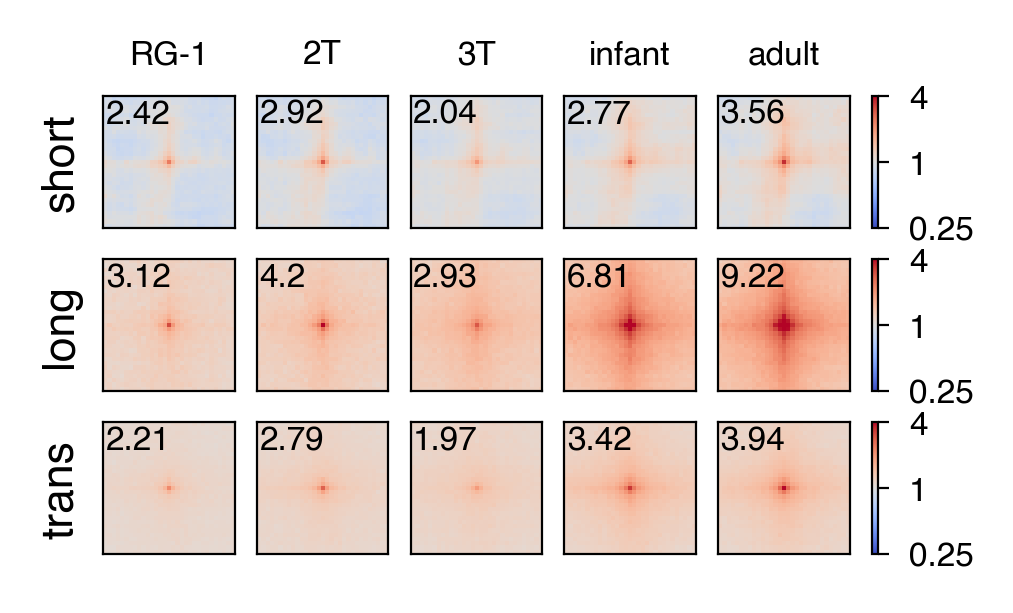

In [181]:
utils.plot_av_dot_2d(pl_pups, 4)
# plt.savefig("average_dot_intensity_by_distance.pdf", bbox_inches='tight')

## Plot: neuronal RG and all neurons at 4 stages divided into "silent" and "active"

In [182]:
# Select required coolers
pl_clrs = {
    "RG-1": clrs[res]["RG-1"],
    "2T": clrs[res]['Neu_2T'],
    "3T": clrs[res]['Neu_3T'],
    "infant": clrs[res]['Neu_infant'],
    "adult": clrs[res]['Neu_adult'],
}
pl_grps = list(pl_clrs.keys())

In [183]:
# Expected
pl_cvd = {}
nproc = 10
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

RG-1
2T
3T
infant
adult


In [184]:
# Pileup
by_window = False
nproc=15

# Split by distance
pl_pups = {'silent': {}, 'active': {}}
for grp in pl_grps:
    print(grp)
    pl_pups['silent'][grp] = coolpup.pileup(
        pl_clrs[grp],
        hand_anch_d[res].loc[hand_anch_d[res]['noex']],
        view_df=hg38_chromsizes_view,
        expected_df=pl_cvd[grp],
        flank=15 * res,
        mindist=int(3e6),
        by_window=by_window,
        nproc=nproc
    );
    pl_pups['active'][grp] = coolpup.pileup(
        pl_clrs[grp],
        hand_anch_d[res].loc[~hand_anch_d[res]['noex']],
        view_df=hg38_chromsizes_view,
        expected_df=pl_cvd[grp],
        flank=15 * res,
        mindist=int(3e6),
        by_window=by_window,
        nproc=nproc
    );

RG-1


INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr13', 'chr13'): 9
INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr8', 'chr8'): 9
INFO:coolpuppy:('chr11', 'chr11'): 2
INFO:coolpuppy:('chr12', 'chr12'): 15
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr18', 'chr18'): 5
INFO:coolpuppy:('chr10', 'chr10'): 10
INFO:coolpuppy:('chr7', 'chr7'): 14
INFO:coolpuppy:('chr6', 'chr6'): 52
INFO:coolpuppy:('chr4', 'chr4'): 26
INFO:coolpuppy:('chr5', 'chr5'): 108
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 57
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:Total number of piled up windows: 346
INFO:coolpuppy:('chr15', 'chr15'): 15
INFO:coolpuppy:('chr14', 'chr14'): 4
INFO:coolpuppy:('chr13', 'chr13'): 14
INFO:coolpuppy:('chr16', 'chr16'): 5
INFO:coolpuppy:('chr9', 'chr9'): 34
INFO:coolpuppy:('chr11', 'chr11'): 25
INFO:coolpuppy:('chr18', 'chr18'): 2
INFO:coolpuppy:('chr10', 'chr10'): 50
INFO:coolpuppy:('chr20', 'ch

2T


INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr13', 'chr13'): 9
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr12', 'chr12'): 15
INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:('chr11', 'chr11'): 2
INFO:coolpuppy:('chr10', 'chr10'): 10
INFO:coolpuppy:('chr8', 'chr8'): 9
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr7', 'chr7'): 14
INFO:coolpuppy:('chr18', 'chr18'): 5
INFO:coolpuppy:('chr6', 'chr6'): 52
INFO:coolpuppy:('chr4', 'chr4'): 26
INFO:coolpuppy:('chr5', 'chr5'): 108
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:('chr1', 'chr1'): 57
INFO:coolpuppy:Total number of piled up windows: 346
INFO:coolpuppy:('chr15', 'chr15'): 15
INFO:coolpuppy:('chr14', 'chr14'): 4
INFO:coolpuppy:('chr13', 'chr13'): 14
INFO:coolpuppy:('chr16', 'chr16'): 5
INFO:coolpuppy:('chr11', 'chr11'): 25
INFO:coolpuppy:('chr9', 'chr9'): 34
INFO:coolpuppy:('chr10', 'chr10'): 50
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr17', 'ch

3T


INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr13', 'chr13'): 9
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:('chr11', 'chr11'): 2
INFO:coolpuppy:('chr12', 'chr12'): 15
INFO:coolpuppy:('chr10', 'chr10'): 10
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr8', 'chr8'): 9
INFO:coolpuppy:('chr18', 'chr18'): 5
INFO:coolpuppy:('chr7', 'chr7'): 14
INFO:coolpuppy:('chr6', 'chr6'): 52
INFO:coolpuppy:('chr5', 'chr5'): 108
INFO:coolpuppy:('chr4', 'chr4'): 26
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 57
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:Total number of piled up windows: 346
INFO:coolpuppy:('chr14', 'chr14'): 4
INFO:coolpuppy:('chr15', 'chr15'): 15
INFO:coolpuppy:('chr13', 'chr13'): 14
INFO:coolpuppy:('chr9', 'chr9'): 34
INFO:coolpuppy:('chr16', 'chr16'): 5
INFO:coolpuppy:('chr11', 'chr11'): 25
INFO:coolpuppy:('chr10', 'chr10'): 50
INFO:coolpuppy:('chr17', 'chr17'): 14
INFO:coolpuppy:('chr20', 'c

infant


INFO:coolpuppy:('chr13', 'chr13'): 9
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr12', 'chr12'): 15
INFO:coolpuppy:('chr11', 'chr11'): 2
INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:('chr10', 'chr10'): 10
INFO:coolpuppy:('chr8', 'chr8'): 9
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr18', 'chr18'): 5
INFO:coolpuppy:('chr7', 'chr7'): 14
INFO:coolpuppy:('chr6', 'chr6'): 52
INFO:coolpuppy:('chr5', 'chr5'): 108
INFO:coolpuppy:('chr4', 'chr4'): 26
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:('chr1', 'chr1'): 57
INFO:coolpuppy:Total number of piled up windows: 346
INFO:coolpuppy:('chr14', 'chr14'): 4
INFO:coolpuppy:('chr15', 'chr15'): 15
INFO:coolpuppy:('chr9', 'chr9'): 34
INFO:coolpuppy:('chr13', 'chr13'): 14
INFO:coolpuppy:('chr8', 'chr8'): 14
INFO:coolpuppy:('chr10', 'chr10'): 50
INFO:coolpuppy:('chr17', 'chr17'): 14
INFO:coolpuppy:('chr16', 'chr16'): 5
INFO:coolpuppy:('chr11', 'chr

adult


INFO:coolpuppy:('chr13', 'chr13'): 9
INFO:coolpuppy:('chr14', 'chr14'): 6
INFO:coolpuppy:('chr11', 'chr11'): 2
INFO:coolpuppy:('chr9', 'chr9'): 6
INFO:coolpuppy:('chr10', 'chr10'): 10
INFO:coolpuppy:('chr12', 'chr12'): 15
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr8', 'chr8'): 9
INFO:coolpuppy:('chr7', 'chr7'): 14
INFO:coolpuppy:('chr18', 'chr18'): 5
INFO:coolpuppy:('chr6', 'chr6'): 52
INFO:coolpuppy:('chr5', 'chr5'): 108
INFO:coolpuppy:('chr4', 'chr4'): 26
INFO:coolpuppy:('chr3', 'chr3'): 2
INFO:coolpuppy:('chr1', 'chr1'): 57
INFO:coolpuppy:('chr2', 'chr2'): 20
INFO:coolpuppy:Total number of piled up windows: 346
INFO:coolpuppy:('chr15', 'chr15'): 15
INFO:coolpuppy:('chr14', 'chr14'): 4
INFO:coolpuppy:('chr13', 'chr13'): 14
INFO:coolpuppy:('chr9', 'chr9'): 34
INFO:coolpuppy:('chr11', 'chr11'): 25
INFO:coolpuppy:('chr10', 'chr10'): 50
INFO:coolpuppy:('chr16', 'chr16'): 5
INFO:coolpuppy:('chr8', 'chr8'): 14
INFO:coolpuppy:('chr17', 'chr

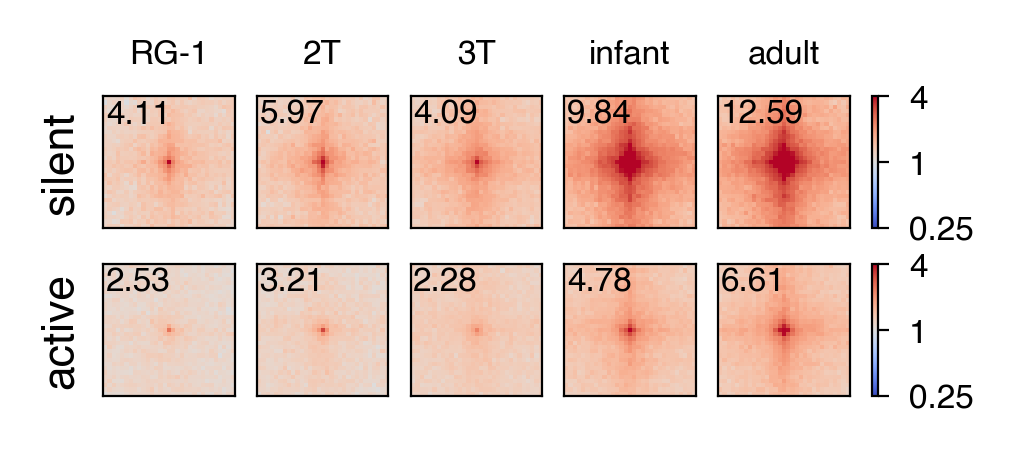

In [188]:
utils.plot_av_dot_2d(pl_pups, 4)
# plt.savefig("average_dot_intensity_by_expression.pdf", bbox_inches='tight')

# Dots with highest and lowest PCA loadings

In [199]:
# Select required coolers
res = 100_000
pl_clrs = {
    "EN_2T": clrs[res]['EN_2T'],
    "EN_3T": clrs[res]['EN_3T'],
    "EN_infant": clrs[res]['EN_infant'],
    "EN_adult": clrs[res]['EN_adult'],
    "IN_2T": clrs[res]['IN_2T'],
    "IN_3T": clrs[res]['IN_3T'],
    "IN_infant": clrs[res]['IN_infant'],
    "IN_adult": clrs[res]['IN_adult'],
}
pl_grps = list(pl_clrs.keys())

In [200]:
# Expected
pl_cvd = {}
nproc = 10
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

EN_2T
EN_3T
EN_infant
EN_adult
IN_2T
IN_3T
IN_infant
IN_adult


In [219]:
pca_load = utils.parse_pca_df(pca_loads_path, hand_anch)#.reset_index()
pca_load.head(1)

PC1       PC2       PC3       PC4 chrom1    start1      end1 chrom2  \
0  0.022435 -0.007342  0.002345 -0.006491   chr1  18630000  18640000   chr1   

     start2      end2 gene1  gene2           genes  
0  24930000  24940000  PAX7  RUNX3  PAX7 <-> RUNX3

### Plot: PC1

In [229]:
# Extract regions (snippets) from contact matrix
pca_top = pd.concat([pca_load.nlargest(20, 'PC1'), 
                     pca_load.nsmallest(20, 'PC1')]).reset_index(drop=True)
pca_top = bf.sort_bedframe(pca_top, cols=['chrom1', 'start1', 'end1'], 
                           reset_index=False)

snips = subt_snips_cache(pca_top, pl_clrs, pl_cvd, hg38_chromsizes_view, nbin_flank=6)

EN_2T
EN_3T
EN_infant
EN_adult
IN_2T
IN_3T
IN_infant
IN_adult


In [231]:
pca_top

PC1       PC2       PC3       PC4 chrom1     start1       end1  \
8   0.074982 -0.017459 -0.061499 -0.003141   chr1   18630000   18640000   
12  0.070833  0.002792 -0.049799  0.006974   chr1   18630000   18640000   
0   0.097353 -0.020283 -0.069707  0.002415   chr1   24930000   24940000   
13  0.070232  0.028196 -0.036510  0.021134   chr1   24930000   24940000   
28 -0.019651 -0.005513 -0.026780 -0.026643   chr1   44410000   44420000   
39 -0.017910 -0.022495 -0.024188  0.067192   chr1   46480000   46490000   
1   0.097353 -0.020283 -0.069707  0.002415   chr1   47710000   47720000   
7   0.075483  0.018811 -0.042936  0.017510   chr1   50415000   50430000   
15  0.069307  0.011947 -0.044614  0.011658   chr1   63320000   63330000   
2   0.097353 -0.020283 -0.069707  0.002415   chr1  118180000  118190000   
35 -0.018208 -0.003712 -0.019440 -0.006439   chr1  118180000  118190000   
18  0.066988 -0.030561  0.018226 -0.003342  chr10   22320000   22350000   
34 -0.018336 -0.002915 -0.025761 -0.058071  chr13   27370000   27380000   
16  0.069177 -0.014557 -0.058191 -0.029499  chr17   14300000   14320000   
19  0.065931  0.014600 -0.039628 -0.005557   chr2    5690000    5700000   
29 -0.019651 -0.005513 -0.026780 -0.026643   chr2    5690000    5700000   
32 -0.019128  0.010698 -0.009488  0.040003   chr2    5690000    5700000   
9   0.074419 -0.021065 -0.059844  0.031384   chr2   19350000   19360000   
25 -0.021184  0.007042 -0.009905  0.013629   chr2   44930000   44940000   
4   0.081288 -0.026635 -0.018987  0.000961   chr2   45000000   45010000   
22 -0.022780 -0.003009 -0.017199  0.003918   chr2   45000000   45010000   
14  0.069580 -0.006044 -0.053979  0.001582   chr2   63050000   63060000   
27 -0.019989  0.002562 -0.017591 -0.017866   chr2   63050000   63060000   
33 -0.018803 -0.004454 -0.022465 -0.014764   chr2   66430000   66440000   
3   0.097353 -0.020283 -0.069707  0.002415   chr2   66575000   66585000   
5   0.077690 -0.020953 -0.061251  0.027251   chr2   66575000   66585000   
20 -0.028524 -0.019867 -0.022379  0.010545   chr2   72140000   72150000   
36 -0.018128 -0.016107 -0.023242  0.071805   chr2   72140000   72150000   
21 -0.023269 -0.026297 -0.022585  0.073048   chr2   72910000   72920000   
30 -0.019651 -0.005513 -0.026780 -0.026643   chr2   72910000   72920000   
23 -0.022085 -0.001613 -0.014359  0.037780   chr2   74455000   74465000   
37 -0.018014 -0.016897 -0.022978  0.079147   chr2   74455000   74465000   
38 -0.018006 -0.002262 -0.025505 -0.065971   chr2   74455000   74465000   
24 -0.021322 -0.006307 -0.017430  0.021227   chr2  118218000  118228000   
6   0.076559 -0.022070 -0.035434 -0.003656   chr2  161410000  161430000   
10  0.072301 -0.001958 -0.032357 -0.000840   chr3   62350000   62380000   
31 -0.019651 -0.005513 -0.026780 -0.026643   chr4   54220000   54230000   
17  0.067611 -0.008939 -0.049773 -0.035332   chr5   52780000   52790000   
11  0.072145 -0.008315 -0.053878 -0.004824   chr5   55220000   55230000   
26 -0.021148 -0.007357 -0.018957  0.026684   chr6  106070000  106102000   

   chrom2     start2       end2                         gene1  \
8    chr1   90830000   90840000                          PAX7   
12   chr1   63320000   63330000                          PAX7   
0    chr1  200030000  200040000                         RUNX3   
13   chr1  165350000  165360000                         RUNX3   
28   chr1  197910000  197920000                        RNF220   
39   chr1  220880000  220890000                       locus_0   
1    chr1  197910000  197920000                       locus_1   
7    chr1  197910000  197920000             DMRTA2,AL049637.2   
15   chr1  213980000  213990000       FOXD3,FOXD3-AS1,MIR6068   
2    chr1  213980000  213990000                        SPAG17   
35   chr1  180230000  180240000                        SPAG17   
18  chr10  100720000  100760000              SPAG6,AL158211.3   
34  chr13   52850000   52860000                     LINC01079   
16  chr17   49960000   

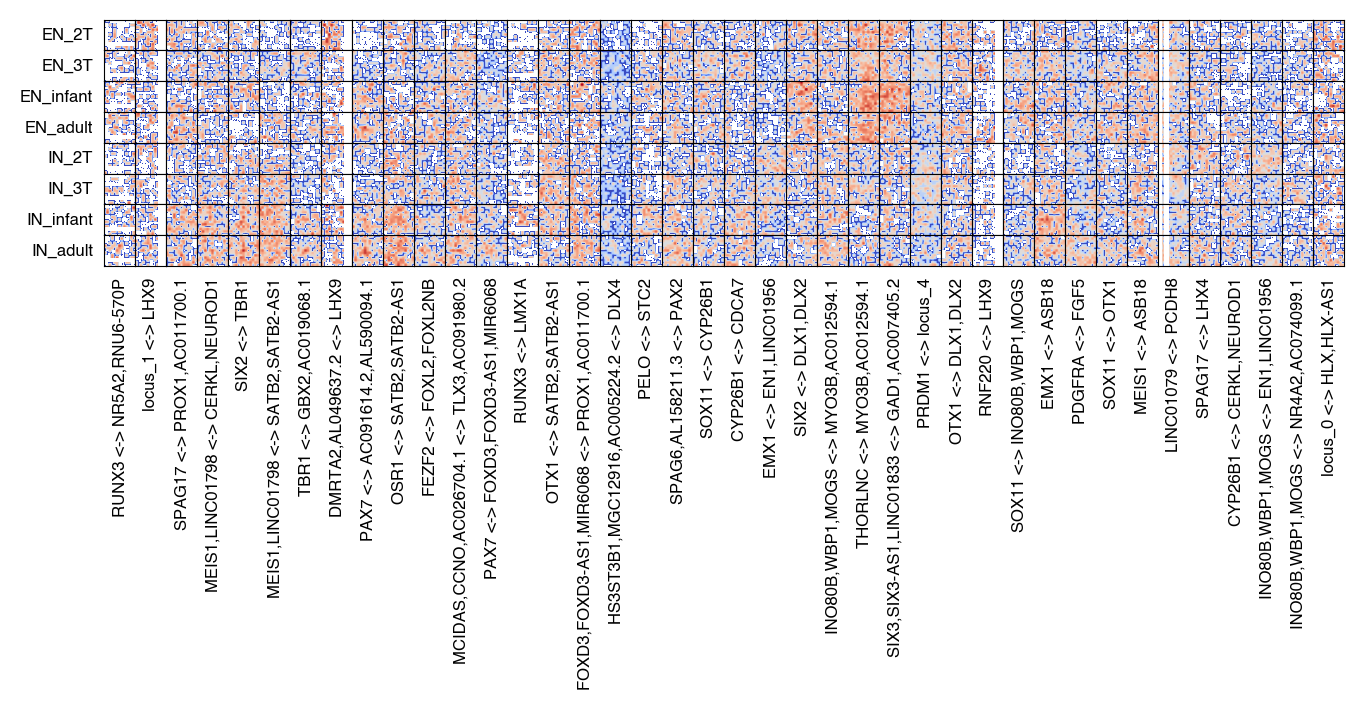

In [230]:
utils.plot_loads(pca_top, pl_grps, snips)
# plt.savefig('heffel.top_bottom_pca_dots.pc1.pdf', bbox_inches='tight')

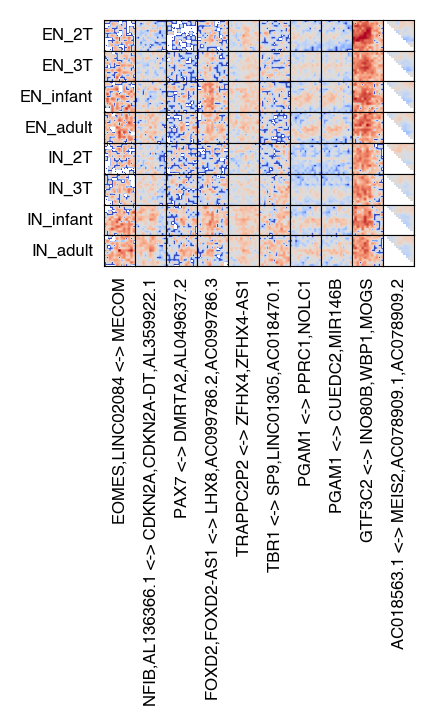

In [213]:
utils.plot_loads(pca_top, pl_grps, snips)
# plt.savefig('heffel.top_bottom_pca_dots.pc1.pdf', bbox_inches='tight')

### Plot: PC2

In [232]:
pca_top = pd.concat([pca_load.nlargest(20, 'PC2'), 
                     pca_load.nsmallest(20, 'PC2')]).reset_index(drop=True)
pca_top = bf.sort_bedframe(pca_top, cols=['chrom1', 'start1', 'end1'], 
                           reset_index=False)

snips = subt_snips_cache(pca_top, pl_clrs, pl_cvd, hg38_chromsizes_view, nbin_flank=6)

EN_2T
EN_3T
EN_infant
EN_adult
IN_2T
IN_3T
IN_infant
IN_adult


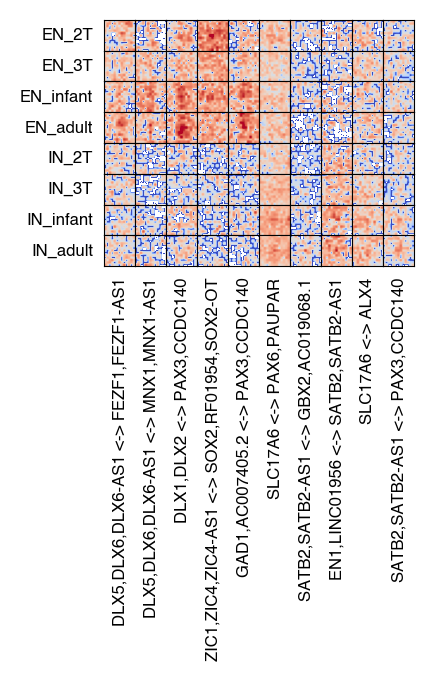

In [217]:
utils.plot_loads(pca_top, pl_grps, snips)
# plt.savefig('heffel.top_bottom_pca_dots.pc2.pdf', bbox_inches='tight')

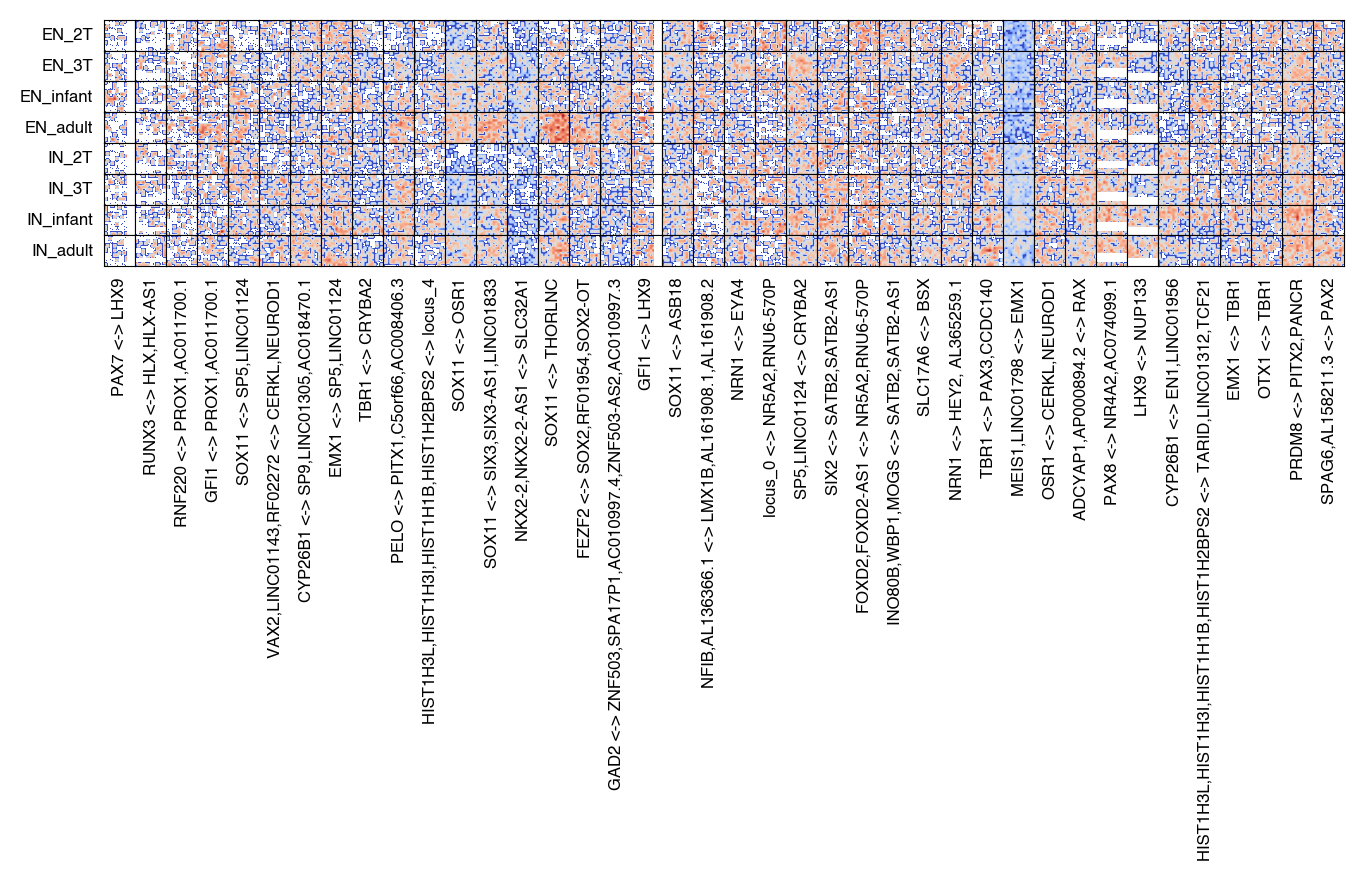

In [233]:
utils.plot_loads(pca_top, pl_grps, snips)
# plt.savefig('heffel.top_bottom_pca_dots.pc2.pdf', bbox_inches='tight')

# Fetal H3K27me3

Assuming that there are long-range PcG contacts in fetal neurons that are absent from adult neurons, take unique fetal H3K27me3 ChIP-seq peaks and extract contact frequencies from all pairs of such regions. Compare the resulting frequency distribution with distribution obtained when using adult-only H3K27me3 peaks.

Since PcG contacts in adult neurons anchor large H3K27me3 peaks (> 10kb), for fetal data, we also consider only large peaks

There are no publicly available peaks for fetal sample, instead, we use regions from chromHMM annotation

In [288]:
# Select required coolers
res = 100_000
pl_clrs = {
    "2T": clrs[res]['Neu_2T'],
    "3T": clrs[res]['Neu_3T'],
    "infant": clrs[res]['Neu_infant'],
    "adult": clrs[res]['Neu_adult'],
}
pl_grps1 = list(pl_clrs.keys())
pl_grps2 = ['fet', 'adu']

In [289]:
# Expected
pl_cvd = {}
nproc = 10
for grp in pl_grps1:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=False,
        nproc=nproc
    )

2T
3T
infant
adult


In [290]:
# Read H3K27me3 peaks
grps = list(me3_path.keys())
me3_df = {
    grp: bf.read_table(path, schema='narrowPeak').drop(columns='relSummit')
    for grp, path in me3_path.items()
}

# Keep only H3K27me3-associted regions in chromHMM
me3_df['fetal'] = me3_df['fetal'].loc[me3_df['fetal']['name'].isin(['ReprPC', 'TssBiv'])]

for grp in grps:
    print("N peaks:", grp, me3_df[grp].shape[0])
    
me3_df[grps[0]].head()

N peaks: IN 156744
N peaks: EN 185251
N peaks: fetal 75777


chrom   start     end              name  score strand       fc  -log10p  \
0  chr1  664863  665135  GABA_REP1_peak_1     12      .  2.96305  3.20213   
1  chr1  887357  888294  GABA_REP1_peak_2     21      .  3.55056  4.45904   
2  chr1  889968  890512  GABA_REP1_peak_3     14      .  2.98475  3.49629   
3  chr1  927078  927540  GABA_REP1_peak_4     10      .  2.60157  2.72587   
4  chr1  933161  933444  GABA_REP1_peak_5     10      .  2.81331  2.94974   

   -log10q  
0  1.23661  
1  2.15745  
2  1.44463  
3  1.00659  
4  1.08779

In [291]:
# Select adult peaks NOT present in fetal neurons
adu_only = pd.concat([me3_df['EN'], me3_df['IN']], ignore_index=True)
adu_only = bf.setdiff(adu_only, me3_df['fetal'])
adu_only = bf.merge(adu_only)
adu_only['size'] = adu_only['end'] - adu_only['start']

# Keep large peaks
adu_only = adu_only.loc[adu_only['size'] >= 10_000].reset_index(drop=True)
print("N peaks:", adu_only.shape[0])
adu_only.head()

# Get bins from intervals
me3_bins = {}
me3_bins['adu'] = utils.regs_to_bins(adu_only, res, mode='all', return_index=False)\
    .drop_duplicates(subset=['chrom', 'start', 'end'])\
    .reset_index(drop=True)
me3_bins['adu'] = bf.trim(me3_bins['adu'], hg38_chromsizes_view).dropna()
print("N bins:", me3_bins['adu'].shape[0])
me3_bins['adu'].head()

N peaks: 452
N bins: 287


chrom        start          end  n_intervals   size
0  chr1  113200000.0  113300000.0            1  10530
1  chr1  143500000.0  143600000.0            2  14708
2  chr1  143600000.0  143700000.0            1  21391
3  chr1  161400000.0  161500000.0            3  14040
4  chr1  228500000.0  228600000.0            5  10128

In [292]:
# Select fetal peaks NOT present in adult neurons (EN or IN)
fet_only = bf.setdiff(me3_df['fetal'], me3_df['EN'])
fet_only = bf.setdiff(fet_only, me3_df['IN'])
fet_only = bf.merge(fet_only)
fet_only['size'] = fet_only['end'] - fet_only['start']

# Keep large peaks
fet_only = fet_only.loc[fet_only['size'] >= 10_000].reset_index(drop=True)
print("N peaks:", fet_only.shape[0])

# Get bins from intervals
me3_bins['fet'] = utils.regs_to_bins(fet_only, res, mode='all', return_index=False)\
    .drop_duplicates(subset=['chrom', 'start', 'end'])\
    .reset_index(drop=True)
me3_bins['fet'] = bf.trim(me3_bins['fet'], hg38_chromsizes_view).dropna()
print("N bins:", me3_bins['fet'].shape[0])
me3_bins['fet'].head()

N peaks: 2908
N bins: 1672


chrom      start        end  n_intervals   size
0  chr1   800000.0   900000.0            2  12400
1  chr1   900000.0  1000000.0            4  18800
2  chr1  1100000.0  1200000.0            1  11800
3  chr1  1200000.0  1300000.0            5  10600
4  chr1  1500000.0  1600000.0            1  15600

In [293]:
# Pileup
by_window = True
nproc = 20

# Split by distance
pl_pups = {grp: {} for grp in pl_grps1}

for grp1 in pl_grps1:
    for grp2 in pl_grps2:
        print(grp1, grp2)
        pl_pups[grp1][grp2] = coolpup.pileup(
            pl_clrs[grp1],
            me3_bins[grp2],
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[grp1],
            flank=0,
            mindist=int(3e6),
            by_window=by_window,
            nproc=nproc
        );

2T fet


INFO:coolpuppy:('chr15', 'chr15'): 2214
INFO:coolpuppy:('chr18', 'chr18'): 476
INFO:coolpuppy:('chr20', 'chr20'): 5638
INFO:coolpuppy:('chr19', 'chr19'): 6290
INFO:coolpuppy:('chr13', 'chr13'): 620
INFO:coolpuppy:('chr14', 'chr14'): 4204
INFO:coolpuppy:('chr16', 'chr16'): 8562
INFO:coolpuppy:('chr17', 'chr17'): 11248
INFO:coolpuppy:('chr8', 'chr8'): 3492
INFO:coolpuppy:('chr9', 'chr9'): 3586
INFO:coolpuppy:('chr11', 'chr11'): 6920
INFO:coolpuppy:('chr6', 'chr6'): 3442
INFO:coolpuppy:('chr10', 'chr10'): 6200
INFO:coolpuppy:('chr7', 'chr7'): 5802
INFO:coolpuppy:('chr12', 'chr12'): 8828
INFO:coolpuppy:('chr5', 'chr5'): 6172
INFO:coolpuppy:('chr4', 'chr4'): 3956
INFO:coolpuppy:('chr3', 'chr3'): 11784
INFO:coolpuppy:('chr2', 'chr2'): 7640
INFO:coolpuppy:('chr21', 'chr21'): 40
INFO:coolpuppy:('chr22', 'chr22'): 768
INFO:coolpuppy:('chr1', 'chr1'): 38316
INFO:coolpuppy:Total number of piled up windows: 146198


2T adu


INFO:coolpuppy:('chr21', 'chr21'): 216
INFO:coolpuppy:('chr17', 'chr17'): 48
INFO:coolpuppy:('chr8', 'chr8'): 70
INFO:coolpuppy:('chr19', 'chr19'): 262
INFO:coolpuppy:('chr20', 'chr20'): 82
INFO:coolpuppy:('chr13', 'chr13'): 20
INFO:coolpuppy:('chr16', 'chr16'): 288
INFO:coolpuppy:('chr14', 'chr14'): 198
INFO:coolpuppy:('chr15', 'chr15'): 242
INFO:coolpuppy:('chr10', 'chr10'): 88
INFO:coolpuppy:('chr9', 'chr9'): 46
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr11', 'chr11'): 138
INFO:coolpuppy:('chr7', 'chr7'): 234
INFO:coolpuppy:('chr22', 'chr22'): 288
INFO:coolpuppy:('chr4', 'chr4'): 10
INFO:coolpuppy:('chr6', 'chr6'): 12
INFO:coolpuppy:('chr5', 'chr5'): 12
INFO:coolpuppy:('chr3', 'chr3'): 38
INFO:coolpuppy:('chr1', 'chr1'): 28
INFO:coolpuppy:('chr2', 'chr2'): 16
INFO:coolpuppy:Total number of piled up windows: 2358


3T fet


INFO:coolpuppy:('chr16', 'chr16'): 8562
INFO:coolpuppy:('chr18', 'chr18'): 476
INFO:coolpuppy:('chr9', 'chr9'): 3586
INFO:coolpuppy:('chr15', 'chr15'): 2214
INFO:coolpuppy:('chr17', 'chr17'): 11248
INFO:coolpuppy:('chr19', 'chr19'): 6290
INFO:coolpuppy:('chr20', 'chr20'): 5638
INFO:coolpuppy:('chr13', 'chr13'): 620
INFO:coolpuppy:('chr8', 'chr8'): 3492
INFO:coolpuppy:('chr11', 'chr11'): 6920
INFO:coolpuppy:('chr10', 'chr10'): 6200
INFO:coolpuppy:('chr5', 'chr5'): 6172
INFO:coolpuppy:('chr14', 'chr14'): 4204
INFO:coolpuppy:('chr6', 'chr6'): 3442
INFO:coolpuppy:('chr7', 'chr7'): 5802
INFO:coolpuppy:('chr12', 'chr12'): 8828
INFO:coolpuppy:('chr4', 'chr4'): 3956
INFO:coolpuppy:('chr3', 'chr3'): 11784
INFO:coolpuppy:('chr2', 'chr2'): 7640
INFO:coolpuppy:('chr21', 'chr21'): 40
INFO:coolpuppy:('chr22', 'chr22'): 768
INFO:coolpuppy:('chr1', 'chr1'): 38316
INFO:coolpuppy:Total number of piled up windows: 146198


3T adu


INFO:coolpuppy:('chr17', 'chr17'): 48
INFO:coolpuppy:('chr20', 'chr20'): 82
INFO:coolpuppy:('chr16', 'chr16'): 288
INFO:coolpuppy:('chr15', 'chr15'): 242
INFO:coolpuppy:('chr21', 'chr21'): 216
INFO:coolpuppy:('chr19', 'chr19'): 262
INFO:coolpuppy:('chr13', 'chr13'): 20
INFO:coolpuppy:('chr14', 'chr14'): 198
INFO:coolpuppy:('chr8', 'chr8'): 70
INFO:coolpuppy:('chr9', 'chr9'): 46
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr11', 'chr11'): 138
INFO:coolpuppy:('chr10', 'chr10'): 88
INFO:coolpuppy:('chr6', 'chr6'): 12
INFO:coolpuppy:('chr7', 'chr7'): 234
INFO:coolpuppy:('chr22', 'chr22'): 288
INFO:coolpuppy:('chr4', 'chr4'): 10
INFO:coolpuppy:('chr5', 'chr5'): 12
INFO:coolpuppy:('chr1', 'chr1'): 28
INFO:coolpuppy:('chr3', 'chr3'): 38
INFO:coolpuppy:('chr2', 'chr2'): 16
INFO:coolpuppy:Total number of piled up windows: 2358


infant fet


INFO:coolpuppy:('chr15', 'chr15'): 2214
INFO:coolpuppy:('chr13', 'chr13'): 620
INFO:coolpuppy:('chr19', 'chr19'): 6290
INFO:coolpuppy:('chr20', 'chr20'): 5638
INFO:coolpuppy:('chr18', 'chr18'): 476
INFO:coolpuppy:('chr8', 'chr8'): 3492
INFO:coolpuppy:('chr16', 'chr16'): 8562
INFO:coolpuppy:('chr17', 'chr17'): 11248
INFO:coolpuppy:('chr9', 'chr9'): 3586
INFO:coolpuppy:('chr14', 'chr14'): 4204
INFO:coolpuppy:('chr12', 'chr12'): 8828
INFO:coolpuppy:('chr11', 'chr11'): 6920
INFO:coolpuppy:('chr10', 'chr10'): 6200
INFO:coolpuppy:('chr6', 'chr6'): 3442
INFO:coolpuppy:('chr7', 'chr7'): 5802
INFO:coolpuppy:('chr4', 'chr4'): 3956
INFO:coolpuppy:('chr5', 'chr5'): 6172
INFO:coolpuppy:('chr3', 'chr3'): 11784
INFO:coolpuppy:('chr2', 'chr2'): 7640
INFO:coolpuppy:('chr21', 'chr21'): 40
INFO:coolpuppy:('chr22', 'chr22'): 768
INFO:coolpuppy:('chr1', 'chr1'): 38316
INFO:coolpuppy:Total number of piled up windows: 146198


infant adu


INFO:coolpuppy:('chr13', 'chr13'): 20
INFO:coolpuppy:('chr19', 'chr19'): 262
INFO:coolpuppy:('chr16', 'chr16'): 288
INFO:coolpuppy:('chr21', 'chr21'): 216
INFO:coolpuppy:('chr14', 'chr14'): 198
INFO:coolpuppy:('chr20', 'chr20'): 82
INFO:coolpuppy:('chr15', 'chr15'): 242
INFO:coolpuppy:('chr8', 'chr8'): 70
INFO:coolpuppy:('chr17', 'chr17'): 48
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr11', 'chr11'): 138
INFO:coolpuppy:('chr9', 'chr9'): 46
INFO:coolpuppy:('chr10', 'chr10'): 88
INFO:coolpuppy:('chr7', 'chr7'): 234
INFO:coolpuppy:('chr22', 'chr22'): 288
INFO:coolpuppy:('chr6', 'chr6'): 12
INFO:coolpuppy:('chr5', 'chr5'): 12
INFO:coolpuppy:('chr4', 'chr4'): 10
INFO:coolpuppy:('chr3', 'chr3'): 38
INFO:coolpuppy:('chr2', 'chr2'): 16
INFO:coolpuppy:('chr1', 'chr1'): 28
INFO:coolpuppy:Total number of piled up windows: 2358


adult fet


INFO:coolpuppy:('chr18', 'chr18'): 476
INFO:coolpuppy:('chr13', 'chr13'): 620
INFO:coolpuppy:('chr19', 'chr19'): 6290
INFO:coolpuppy:('chr15', 'chr15'): 2214
INFO:coolpuppy:('chr14', 'chr14'): 4204
INFO:coolpuppy:('chr9', 'chr9'): 3586
INFO:coolpuppy:('chr20', 'chr20'): 5638
INFO:coolpuppy:('chr10', 'chr10'): 6200
INFO:coolpuppy:('chr12', 'chr12'): 8828
INFO:coolpuppy:('chr11', 'chr11'): 6920
INFO:coolpuppy:('chr16', 'chr16'): 8562
INFO:coolpuppy:('chr17', 'chr17'): 11248
INFO:coolpuppy:('chr8', 'chr8'): 3492
INFO:coolpuppy:('chr6', 'chr6'): 3442
INFO:coolpuppy:('chr4', 'chr4'): 3956
INFO:coolpuppy:('chr7', 'chr7'): 5802
INFO:coolpuppy:('chr5', 'chr5'): 6172
INFO:coolpuppy:('chr3', 'chr3'): 11784
INFO:coolpuppy:('chr2', 'chr2'): 7640
INFO:coolpuppy:('chr21', 'chr21'): 40
INFO:coolpuppy:('chr22', 'chr22'): 768
INFO:coolpuppy:('chr1', 'chr1'): 38316
INFO:coolpuppy:Total number of piled up windows: 146198


adult adu


INFO:coolpuppy:('chr19', 'chr19'): 262
INFO:coolpuppy:('chr21', 'chr21'): 216
INFO:coolpuppy:('chr14', 'chr14'): 198
INFO:coolpuppy:('chr15', 'chr15'): 242
INFO:coolpuppy:('chr13', 'chr13'): 20
INFO:coolpuppy:('chr11', 'chr11'): 138
INFO:coolpuppy:('chr20', 'chr20'): 82
INFO:coolpuppy:('chr17', 'chr17'): 48
INFO:coolpuppy:('chr16', 'chr16'): 288
INFO:coolpuppy:('chr9', 'chr9'): 46
INFO:coolpuppy:('chr10', 'chr10'): 88
INFO:coolpuppy:('chr7', 'chr7'): 234
INFO:coolpuppy:('chr8', 'chr8'): 70
INFO:coolpuppy:('chr12', 'chr12'): 22
INFO:coolpuppy:('chr5', 'chr5'): 12
INFO:coolpuppy:('chr6', 'chr6'): 12
INFO:coolpuppy:('chr3', 'chr3'): 38
INFO:coolpuppy:('chr4', 'chr4'): 10
INFO:coolpuppy:('chr22', 'chr22'): 288
INFO:coolpuppy:('chr1', 'chr1'): 28
INFO:coolpuppy:('chr2', 'chr2'): 16
INFO:coolpuppy:Total number of piled up windows: 2358


In [294]:
# Prepare dataframe for plotting
pup_df = {}
for grp2 in pl_grps2:
    n_dots = pl_pups[pl_grps1[0]][grp2].shape[0]
    n_grps1 = len(pl_grps1)
    cent_vals = np.empty((n_dots, n_grps1), dtype=float)
    
    for j, grp1 in enumerate(pl_grps1):
        arr = pl_pups[grp1][grp2]['data'].to_list()
        for i, snip in enumerate(arr):
            cent_vals[i, j] = snip[snip.shape[0] // 2, snip.shape[1] // 2]
    
    pup_df[grp2] = pd.DataFrame(data=cent_vals, columns=pl_grps1).dropna()
    pup_df[grp2] = pup_df[grp2].melt(var_name='snm3c_seq')
    pup_df[grp2]['me3'] = grp2

plot_df = pd.concat([pup_df[grp2] for grp2 in pl_grps2], ignore_index=True)
plot_df = plot_df.loc[plot_df['value'] > 0]

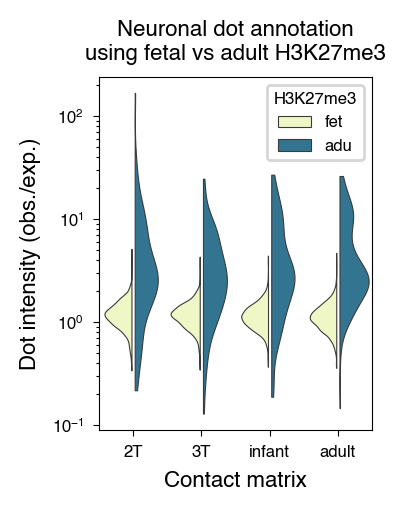

In [298]:
plt.figure(dpi=200, figsize=[2, 2.6])
palette_fetal = {
    'fet': "#f3ffbd",
    'adu': "#247ba0"
}
sns.violinplot(data=plot_df, 
               x='snm3c_seq', 
               y='value', 
               hue='me3', 
               split=True, 
               gap=.1, 
               inner=None, 
               width=0.95, 
               log_scale=10, 
               linewidth=0.4,
               palette=palette_fetal,
               cut=0)
plt.ylabel('Dot intensity (obs./exp.)')
plt.xlabel('Contact matrix')
plt.legend(loc="upper right", fontsize=6, 
           title='H3K27me3', title_fontsize=6)
plt.title("Neuronal dot annotation\nusing fetal vs adult H3K27me3")
plt.tight_layout()
# plt.savefig("violin_fetal_vs_adult_dots.pdf")

In [324]:
# calculate ANOVA
from scipy.stats import f_oneway


a = plot_df.loc[(plot_df['me3'] == 'fet')].groupby('snm3c_seq').agg(list)['value'].values
f_oneway(a[2], a[3])

F_onewayResult(statistic=3.952541627274318, pvalue=0.04689047390912584)

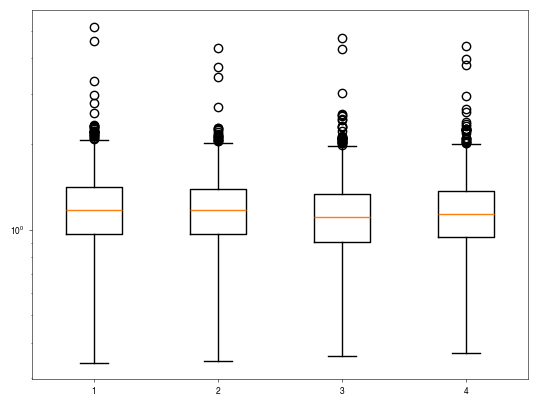

In [323]:
plt.boxplot(plot_df.loc[(plot_df['me3'] == 'fet')].groupby('snm3c_seq').agg(list)['value'].values);
plt.yscale('log')

# Run pyDESEQ2

In [325]:
# Read count data
pb_df = pd.read_csv(pb_df_path, index_col=0)
pb_df.head()

ga22_PN  ga22_IN  ga24_PN  ga24_IN  ga34_PN  ga34_IN  118d_PN  \
RP11-34P13.7        32        1       22        1       21        2       28   
AL627309.1           7        0       10        0        6        0        6   
RP11-34P13.14        5        0        1        0        0        1        1   
AP006222.2         648       59      618       34      138       25      680   
RP4-669L17.10      312       41      349       29      837      131      412   

               118d_IN  179d_PN  179d_IN  20yr_PN  20yr_IN  25yr_PN  25yr_IN  
RP11-34P13.7        14        3        1       45        9       47       18  
AL627309.1           1        2        0       25        4       11        3  
RP11-34P13.14        2        0        0        0        0        1        0  
AP006222.2         317      178      102      448      191      479      301  
RP4-669L17.10      129      236       67      616      283      325      159

In [3]:
!conda list | grep pydeseq2

WARNING conda.gateways.disk.delete:unlink_or_rename_to_trash(140): Could not remove or rename /opt/tljh/user/conda-meta/requests-2.28.2-pyhd8ed1ab_1.json.  Please remove this file manually (you may need to reboot to free file handles)


In [326]:
# Create an object for DE analysis
pbulk = utils.Pb_de(pb_df, hand_pc)

## Fetal

In Herring et al. dataset, there is only one sample correspoding to 3T, therefore, we combined 2T and 3T timepoints into "fetal"

In [327]:
# Perform DE analysis
age = 'fetal'
pbulk.age_deseq2(age)

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 10.38 seconds.

Fitting dispersion trend curve...
... done in 1.87 seconds.

Fitting MAP dispersions...
... done in 12.68 seconds.

Fitting LFCs...
... done in 10.39 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: ct PN vs IN
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.7     6.130580        0.982299  1.038818  0.945593  0.344356   
AL627309.1       1.253781        2.122785  2.485354  0.854118  0.393040   
RP11-34P13.14    0.694217       -1.220861  2.663285 -0.458404  0.646662   
AP006222.2     124.173147        0.058740  0.543533  0.108070  0.913940   
RP4-669L17.10  204.533057        0.089874  0.864527  0.103958  0.917203   
...                   ...             ...       ...       ...       ...   
AL590523.1       0.873487       -1.111204  2.269410 -0.489644  0.624386   
PNRC2-1          5.939986        0.451065  1.023377  0.440762  0.659386   
SRSF10-1        80.609166       -0.270895  0.576757 -0.469687  0.638579   
AC145205.1      11.209818        1.375889  1.107226  1.242645  0.213999   
CU459201.1       2.187572        1.463669  1.916556  0.763697  0.445048   

                   padj  
RP11-34P13.7   0.999822

... done in 12.76 seconds.



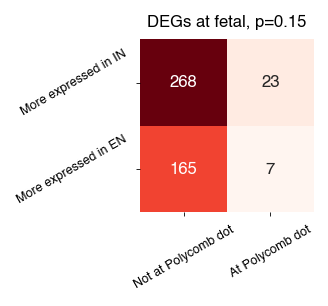

In [328]:
pbulk.cont_table(age)
pbulk.plot_cont(age)

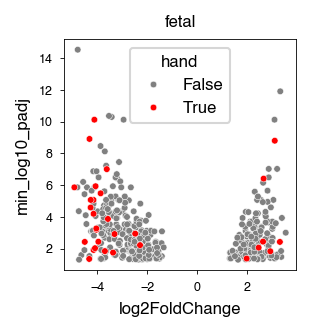

In [329]:
pbulk.plot_volc(age)

## Infant

In [330]:
age = 'infant'
pbulk.age_deseq2(age)

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 11.53 seconds.

Fitting dispersion trend curve...
... done in 1.70 seconds.

/home/ipletenev/.conda/envs/cool/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 19.90 seconds.

Fitting LFCs...
... done in 11.96 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: ct PN vs IN
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.7     6.961624       -0.004241  1.724311 -0.002460  0.998037   
AL627309.1       1.318138        1.773614  3.778436  0.469404  0.638781   
RP11-34P13.14    0.478504       -1.789065  5.020884 -0.356325  0.721597   
AP006222.2     251.822688       -0.254986  0.602519 -0.423201  0.672149   
RP4-669L17.10  179.317981        0.488300  0.672971  0.725589  0.468091   
...                   ...             ...       ...       ...       ...   
AL590523.1       0.097284        0.050921  5.421031  0.009393  0.992505   
PNRC2-1         11.140548        0.901563  1.385533  0.650697  0.515242   
SRSF10-1        89.345218       -0.227132  0.926128 -0.245249  0.806263   
AC145205.1      20.193668       -0.006863  1.073174 -0.006395  0.994898   
CU459201.1       2.439740       -0.553875  2.900729 -0.190944  0.848570   

                   padj  
RP11-34P13.7   0.999987

... done in 21.77 seconds.



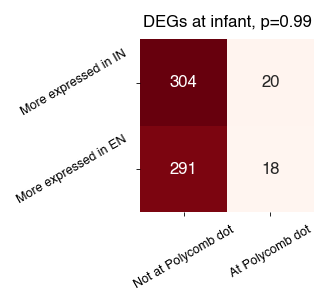

In [331]:
pbulk.cont_table(age)
pbulk.plot_cont(age)

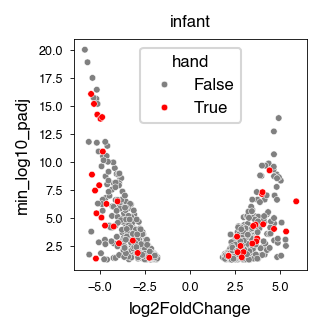

In [332]:
pbulk.plot_volc(age)

## Adult

In [333]:
age = 'adult'
pbulk.age_deseq2(age)

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 10.59 seconds.

Fitting dispersion trend curve...
... done in 1.62 seconds.

/home/ipletenev/.conda/envs/cool/lib/python3.12/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 12.25 seconds.

Fitting LFCs...
... done in 9.21 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: ct PN vs IN
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
RP11-34P13.7    25.770720        0.928536  0.714926  1.298786  0.194017   
AL627309.1       9.036196        1.480791  1.193543  1.240668  0.214729   
RP11-34P13.14    0.183130        0.570433  5.344360  0.106736  0.914999   
AP006222.2     333.367767        0.066246  0.317582  0.208594  0.834765   
RP4-669L17.10  326.746067        0.181057  0.422217  0.428826  0.668050   
...                   ...             ...       ...       ...       ...   
AL590523.1       1.960949       -2.131173  2.514343 -0.847606  0.396657   
PNRC2-1          9.226275        0.247796  1.189435  0.208331  0.834971   
SRSF10-1       120.007479       -0.143970  0.442862 -0.325089  0.745114   
AC145205.1      25.389272        1.261609  0.774180  1.629606  0.103185   
CU459201.1       2.032589        2.255134  2.654206  0.849646  0.395522   

                   padj  
RP11-34P13.7   0.689559

... done in 20.56 seconds.



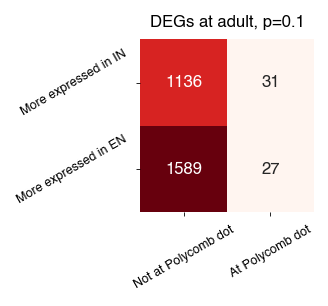

In [334]:
pbulk.cont_table(age)
pbulk.plot_cont(age)

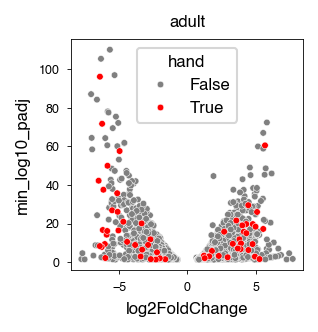

In [335]:
pbulk.plot_volc('adult')

## Plot: upsetplot of overlap between DE genes at different stages

Are there ("inconsistent") genes that are more more expressed in EN at one stage and more expressed in IN - at another stage?

In [336]:
ages = ['fetal', 'infant', 'adult']
res_df_mrg = pbulk.results_df[ages[0]].copy() # first one

if len(ages) < 2:
    raise ValueError("At least two ages required")
elif len(ages) == 2:
    res_df_mrg = res_df_mrg.join(pbulk.results_df[ages[1]], how='outer', 
                                 lsuffix=f'_{ages[0]}', rsuffix=f'_{ages[1]}')
else:
    for i in range(len(ages) - 2):
        res_df_mrg = res_df_mrg\
            .join(pbulk.results_df[ages[i+1]], how='outer', lsuffix=f'_{ages[i]}', rsuffix=f'_{ages[i+1]}')
    # last one
    last_pb = pbulk.results_df[ages[-1]].copy(deep=True).add_suffix(f'_{ages[-1]}') # for correct column names
    res_df_mrg = res_df_mrg.join(last_pb, how='outer')

for age in ages:
    res_df_mrg[f'signif_{age}'] = res_df_mrg[f'padj_{age}'] < 0.05
    res_df_mrg.loc[:, f'lfc_signif_{age}'] = res_df_mrg[f'signif_{age}'] * res_df_mrg.loc[:, f'lfc_sign_{age}']

res_df_de = res_df_mrg\
    .loc[res_df_mrg[f'hand_{ages[0]}'] & 
         np.any(res_df_mrg[[f'padj_{age}' for age in ages]] < 0.05, axis=1)]

en_de = np.any(res_df_de[[f'lfc_signif_{age}' for age in ages]].values == 1, axis=1)
in_de = np.any(res_df_de[[f'lfc_signif_{age}' for age in ages]].values == -1, axis=1)
incons_de = en_de & in_de
print("Number of inconsistent genes:", incons_de.sum())

Number of inconsistent genes: 0


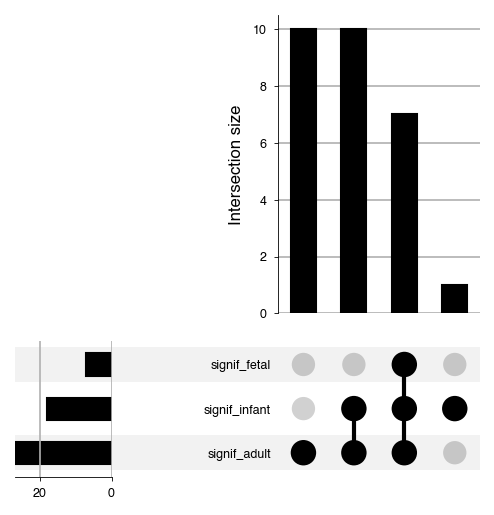

In [339]:
# EN
from upsetplot import plot

vc_en = res_df_de.loc[en_de, [f'signif_{age}' for age in ages]].value_counts()

fig = plt.figure(dpi=150)
plot(vc_en, sort_by="cardinality", sort_categories_by='-input', fig=fig);
# plt.savefig(f"upset_EN.pdf")

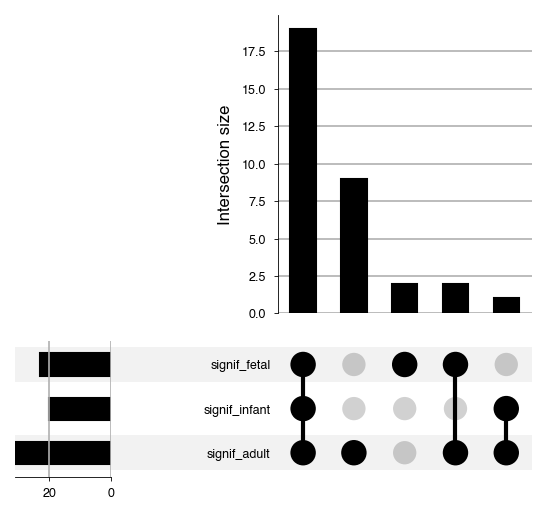

In [338]:
# IN
from upsetplot import plot

vc_in = res_df_de.loc[in_de, [f'signif_{age}' for age in ages]].value_counts()
fig = plt.figure(dpi=150)
plot(vc_in, sort_by="cardinality", sort_categories_by='-input', fig=fig);
# plt.savefig(f"upset_IN.pdf")

## Plot: heatmap and boxplots for DE genes

In [340]:
# Load mean expression obtained from Herring et al.
heff_expr = {
    ct: pd.read_table(path, sep=',', index_col=0)
    for ct, path in heff_expr_path.items()
}
heff_expr['IN'].head()

2T        3T     adult    infant          gene.id  \
RP11-34P13.7   0.258031  0.366954  0.767961  0.542424  ENSG00000238009   
AL627309.1     0.000000  0.000000  0.262010  0.046894  ENSG00000237683   
RP11-34P13.14  0.000000  0.200215  0.000000  0.091688  ENSG00000239906   
AP006222.2     2.687074  1.878189  3.093464  3.050068  ENSG00000228463   
RP4-669L17.10  2.425092  3.402471  2.991411  2.342789  ENSG00000237094   

               highly_variable  
RP11-34P13.7             False  
AL627309.1               False  
RP11-34P13.14            False  
AP006222.2               False  
RP4-669L17.10            False

In [341]:
heff_expr_comb = heff_expr['PN'].join(heff_expr['IN'], how='inner', lsuffix='_EN', rsuffix='_IN')

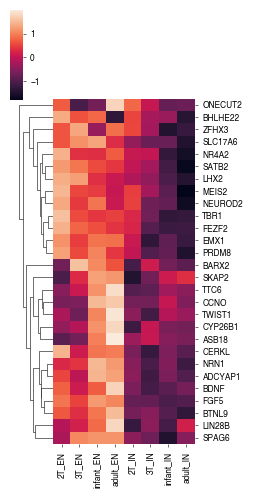

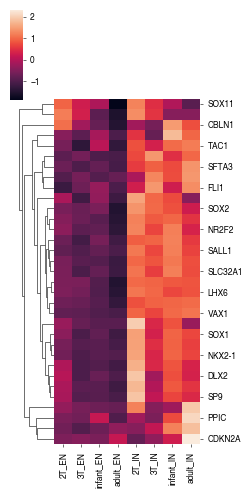

In [342]:
degs = {
    'EN': res_df_de.loc[en_de].index,
    'IN': res_df_de.loc[in_de].index,
    'all': res_df_de.loc[in_de].index.union(res_df_de.loc[en_de].index)
} 
expr_cols = ['2T_EN', '3T_EN', 'infant_EN', 'adult_EN', 
             '2T_IN', '3T_IN', 'infant_IN', 'adult_IN']

for i, ct in enumerate(['EN', 'IN']):
    heff_expr_z = heff_expr_comb.loc[degs[ct], expr_cols].copy(deep=True)
    heff_expr_z = heff_expr_z.sub(heff_expr_z.mean(axis=1), axis=0).div(heff_expr_z.std(axis=1), axis=0)
    sns.clustermap(heff_expr_z, col_cluster=False, figsize=(2.5, 5))
    # plt.savefig(f"heatmap_ages_degs.{ct}.pdf")

EN 0.14377250522375107 EN 0.003738619387149811 EN 0.6136380508542061 EN 0.18578492105007172 EN 0.03660209017913067 EN 0.17090606689453125 EN 0.014598868787288666 EN 0.0024397894740104675
IN 9.082956239581108e-06 IN 0.5134843902196735 IN 4.5744431572838726e-05 IN 2.935994416475296e-07 IN 0.0022327967453747988 IN 0.015230289660394192 IN 0.3214736534282565 IN 0.25653275568038225


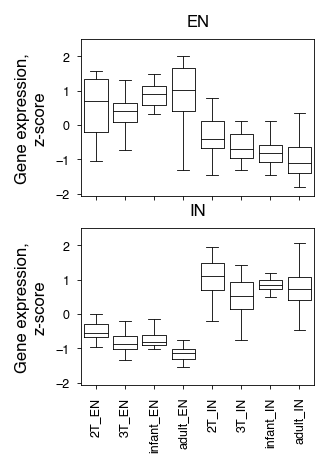

In [343]:
degs = {
    'EN': res_df_de.loc[en_de].index,
    'IN': res_df_de.loc[in_de].index,
    'all': res_df_de.loc[in_de].index.union(res_df_de.loc[en_de].index)
} 
expr_cols = ['2T_EN', '3T_EN', 'infant_EN', 'adult_EN', 
             '2T_IN', '3T_IN', 'infant_IN', 'adult_IN']

fig, axs = plt.subplots(2, 1, dpi=150, sharey=True, figsize=[2, 3], sharex=True)

for i, ct in enumerate(['EN', 'IN']):
    ax = axs[i]
    heff_expr_z = heff_expr_comb.loc[degs[ct], expr_cols].copy(deep=True)
    heff_expr_z = heff_expr_z.sub(heff_expr_z.mean(axis=1), axis=0).div(heff_expr_z.std(axis=1), axis=0)
    sns.boxplot(heff_expr_z, ax=ax, linewidth=0.4, fill=False, fliersize=0, color='black')
    ax.set_ylabel("Gene expression,\nz-score", fontsize=8)
    print(
        ct, wilcoxon(heff_expr_z['2T_EN'], heff_expr_z['3T_EN']).pvalue,
        ct, wilcoxon(heff_expr_z['3T_EN'], heff_expr_z['infant_EN']).pvalue,
        ct, wilcoxon(heff_expr_z['infant_EN'], heff_expr_z['adult_EN']).pvalue,
        ct, wilcoxon(heff_expr_z['2T_EN'], heff_expr_z['adult_EN']).pvalue,
        ct, wilcoxon(heff_expr_z['2T_IN'], heff_expr_z['3T_IN']).pvalue,
        ct, wilcoxon(heff_expr_z['3T_IN'], heff_expr_z['infant_IN']).pvalue,
        ct, wilcoxon(heff_expr_z['infant_IN'], heff_expr_z['adult_IN']).pvalue,
        ct, wilcoxon(heff_expr_z['2T_IN'], heff_expr_z['adult_IN']).pvalue,
    )
    ax.set_title(ct)
    ax.set_xticks(np.arange(len(expr_cols)), expr_cols, rotation=90, fontsize=6)

# plt.savefig('boxplot.gene_expr.age_degs.pdf')

## Calculate average loops for genes differentially expressed between EN and IN in any stage

Make pairs from DE genes and non-expressed genes

In [344]:
# Select required coolers
res = 100_000
pl_clrs = {
    "EN_2T": clrs[res]['EN_2T'],
    "EN_3T": clrs[res]['EN_3T'],
    "EN_infant": clrs[res]['EN_infant'],
    "EN_adult": clrs[res]['EN_adult'],
    "IN_2T": clrs[res]['IN_2T'],
    "IN_3T": clrs[res]['IN_3T'],
    "IN_infant": clrs[res]['IN_infant'],
    "IN_adult": clrs[res]['IN_adult'],
}
pl_grps = list(pl_clrs.keys())

In [345]:
# Expected
pl_cvd = {}
nproc = 10
for grp in pl_grps:
    print(grp)
    pl_cvd[grp] = expected_cis_cache(
        pl_clrs[grp],
        view_df=hg38_chromsizes_view,
        smooth=True,
        nproc=nproc
    )

EN_2T
EN_3T
EN_infant
EN_adult
IN_2T
IN_3T
IN_infant
IN_adult


In [346]:
hand_anch_d[res]['gene_lst'] = hand_anch_d[res]['genes'].str.split(',')
hand_anch_d[res]['de_EN'] = hand_anch_d[res]['gene_lst']\
    .apply(lambda gl: True if len([g for g in gl if g in degs['EN']]) > 0 else False)
hand_anch_d[res]['de_IN'] = hand_anch_d[res]['gene_lst']\
    .apply(lambda gl: True if len([g for g in gl if g in degs['IN']]) > 0 else False)

In [347]:
pair_sites = bf.pair_by_distance(
    hand_anch_d[res], min_sep=3_000_000, max_sep=int(1e10), suffixes=('1', '2'), 
)

In [348]:
pair_ct_noex = {
    ct: pair_sites.loc[(pair_sites['noex1'] & pair_sites[f'de_{ct}2']) | 
                       (pair_sites['noex2'] & pair_sites[f'de_{ct}1'])]
    for ct in ['EN', 'IN']
}

for ct in ['EN', 'IN']:
    print(pair_ct_noex[ct].shape)

(157, 16)
(174, 16)


In [349]:
# For all polycomb dot anchors
nproc=10

# Split by distance
pups_ct = {de_ct: {} for de_ct in ['EN', 'IN']}
for de_ct in ['EN', 'IN']:
    for grp in pl_grps:
        print(de_ct, grp)
        pups_ct[de_ct][grp] = coolpup.pileup(
            pl_clrs[grp],
            pair_ct_noex[de_ct],
            features_format='bedpe',
            view_df=hg38_chromsizes_view,
            expected_df=pl_cvd[grp],
            flank=4 * res,
            mindist=int(3e6),
            nproc=nproc
        );

EN EN_2T


INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr6', 'chr6'): 21
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr2', 'chr2'): 48
INFO:coolpuppy:('chr18', 'chr18'): 6
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr5', 'chr5'): 32
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:Total number of piled up windows: 157


EN EN_3T


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr18', 'chr18'): 6
INFO:coolpuppy:('chr6', 'chr6'): 21
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr5', 'chr5'): 32
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr2', 'chr2'): 48
INFO:coolpuppy:Total number of piled up windows: 157


EN EN_infant


INFO:coolpuppy:('chr6', 'chr6'): 21
INFO:coolpuppy:('chr5', 'chr5'): 32
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr18', 'chr18'): 6
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr2', 'chr2'): 48
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 157


EN EN_adult


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr18', 'chr18'): 6
INFO:coolpuppy:('chr6', 'chr6'): 21
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr5', 'chr5'): 32
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr2', 'chr2'): 48
INFO:coolpuppy:Total number of piled up windows: 157


EN IN_2T


INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr6', 'chr6'): 21
INFO:coolpuppy:('chr5', 'chr5'): 32
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr18', 'chr18'): 6
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr2', 'chr2'): 48
INFO:coolpuppy:Total number of piled up windows: 157


EN IN_3T


INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr5', 'chr5'): 32
INFO:coolpuppy:('chr6', 'chr6'): 21
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr18', 'chr18'): 6
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr2', 'chr2'): 48
INFO:coolpuppy:Total number of piled up windows: 157


EN IN_infant


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr6', 'chr6'): 21
INFO:coolpuppy:('chr5', 'chr5'): 32
INFO:coolpuppy:('chr18', 'chr18'): 6
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr2', 'chr2'): 48
INFO:coolpuppy:Total number of piled up windows: 157


EN IN_adult


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:('chr8', 'chr8'): 5
INFO:coolpuppy:('chr10', 'chr10'): 5
INFO:coolpuppy:('chr11', 'chr11'): 7
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr7', 'chr7'): 10
INFO:coolpuppy:('chr17', 'chr17'): 3
INFO:coolpuppy:('chr5', 'chr5'): 32
INFO:coolpuppy:('chr16', 'chr16'): 2
INFO:coolpuppy:('chr18', 'chr18'): 6
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr6', 'chr6'): 21
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr2', 'chr2'): 48
INFO:coolpuppy:Total number of piled up windows: 157


IN EN_2T


INFO:coolpuppy:('chr9', 'chr9'): 8
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr13', 'chr13'): 8
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr7', 'chr7'): 23
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr6', 'chr6'): 31
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr5', 'chr5'): 16
INFO:coolpuppy:('chr1', 'chr1'): 12
INFO:coolpuppy:('chr2', 'chr2'): 40
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 174


IN EN_3T


INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr9', 'chr9'): 8
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr13', 'chr13'): 8
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr7', 'chr7'): 23
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr6', 'chr6'): 31
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr5', 'chr5'): 16
INFO:coolpuppy:('chr1', 'chr1'): 12
INFO:coolpuppy:('chr2', 'chr2'): 40
INFO:coolpuppy:Total number of piled up windows: 174


IN EN_infant


INFO:coolpuppy:('chr7', 'chr7'): 23
INFO:coolpuppy:('chr5', 'chr5'): 16
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr9', 'chr9'): 8
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr6', 'chr6'): 31
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr13', 'chr13'): 8
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr1', 'chr1'): 12
INFO:coolpuppy:('chr2', 'chr2'): 40
INFO:coolpuppy:Total number of piled up windows: 174


IN EN_adult


INFO:coolpuppy:('chr9', 'chr9'): 8
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr7', 'chr7'): 23
INFO:coolpuppy:('chr13', 'chr13'): 8
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr6', 'chr6'): 31
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr5', 'chr5'): 16
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr1', 'chr1'): 12
INFO:coolpuppy:('chr2', 'chr2'): 40
INFO:coolpuppy:Total number of piled up windows: 174


IN IN_2T


INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr9', 'chr9'): 8
INFO:coolpuppy:('chr7', 'chr7'): 23
INFO:coolpuppy:('chr6', 'chr6'): 31
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr13', 'chr13'): 8
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr5', 'chr5'): 16
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr1', 'chr1'): 12
INFO:coolpuppy:('chr2', 'chr2'): 40
INFO:coolpuppy:Total number of piled up windows: 174


IN IN_3T


INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr9', 'chr9'): 8
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr7', 'chr7'): 23
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr13', 'chr13'): 8
INFO:coolpuppy:('chr5', 'chr5'): 16
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr6', 'chr6'): 31
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr1', 'chr1'): 12
INFO:coolpuppy:('chr2', 'chr2'): 40
INFO:coolpuppy:Total number of piled up windows: 174


IN IN_infant


INFO:coolpuppy:('chr9', 'chr9'): 8
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr5', 'chr5'): 16
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr13', 'chr13'): 8
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr7', 'chr7'): 23
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr6', 'chr6'): 31
INFO:coolpuppy:('chr1', 'chr1'): 12
INFO:coolpuppy:('chr2', 'chr2'): 40
INFO:coolpuppy:Total number of piled up windows: 174


IN IN_adult


INFO:coolpuppy:('chr5', 'chr5'): 16
INFO:coolpuppy:('chr6', 'chr6'): 31
INFO:coolpuppy:('chr7', 'chr7'): 23
INFO:coolpuppy:('chr4', 'chr4'): 8
INFO:coolpuppy:('chr9', 'chr9'): 8
INFO:coolpuppy:('chr13', 'chr13'): 8
INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:('chr10', 'chr10'): 9
INFO:coolpuppy:('chr15', 'chr15'): 1
INFO:coolpuppy:('chr20', 'chr20'): 2
INFO:coolpuppy:('chr14', 'chr14'): 3
INFO:coolpuppy:('chr11', 'chr11'): 6
INFO:coolpuppy:('chr16', 'chr16'): 4
INFO:coolpuppy:('chr1', 'chr1'): 12
INFO:coolpuppy:('chr2', 'chr2'): 40
INFO:coolpuppy:Total number of piled up windows: 174


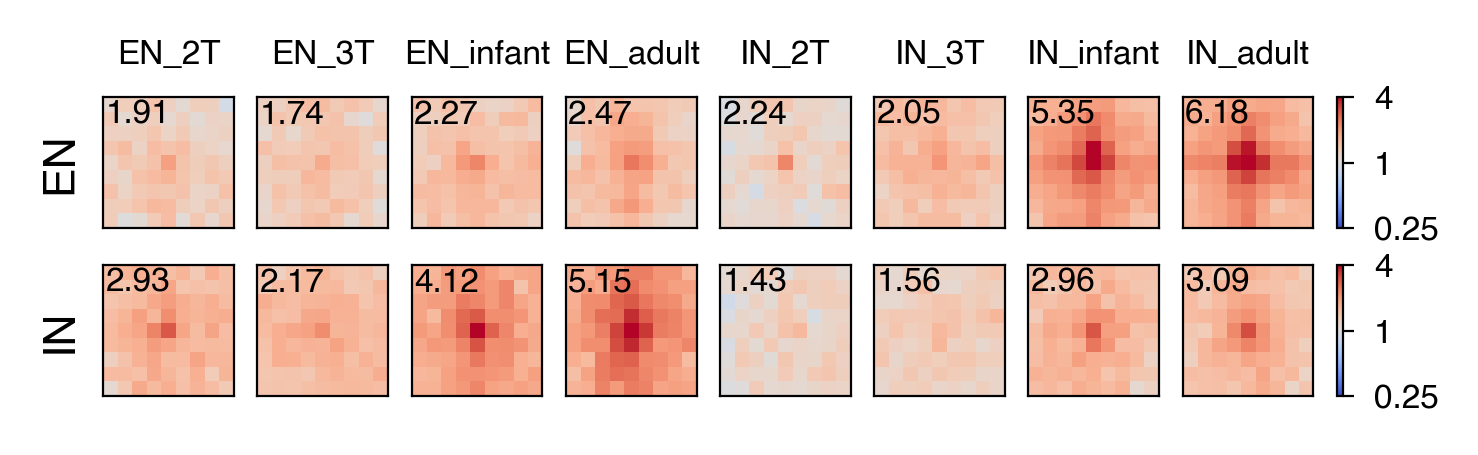

In [351]:
utils.plot_av_dot_2d(pups_ct, 4)
# plt.savefig('av_dot.dev_deg_clust.pdf', bbox_inches='tight')

# Silent vs active genes

In [260]:
# Select required coolers
res = 100_000
pl_clrs = {
    "EN_2T": clrs[res]['EN_2T'],
    "EN_3T": clrs[res]['EN_3T'],
    "EN_infant": clrs[res]['EN_infant'],
    "EN_adult": clrs[res]['EN_adult'],
    "IN_2T": clrs[res]['IN_2T'],
    "IN_3T": clrs[res]['IN_3T'],
    "IN_infant": clrs[res]['IN_infant'],
    "IN_adult": clrs[res]['IN_adult'],
}
pl_grps = list(pl_clrs.keys())

In [261]:
hand_anch_flt = hand_anch_d[res]

In [262]:
hand_noex_map = hand_anch_flt.drop_duplicates('genes').set_index('genes')['noex']

## PC1

-0.0014604126041540407 0.03515366125993994


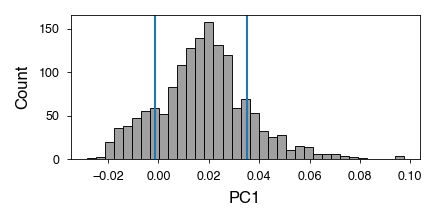

In [252]:
plt.figure(dpi=150, figsize=[3, 1.25])
sns.histplot(pca_load['PC1'], color='grey')
plt.axvline(pca_load['PC1'].quantile(0.15), linewidth=1)
plt.axvline(pca_load['PC1'].quantile(0.85), linewidth=1)
# plt.savefig("pc2_loadings_hist.pdf", bbox_inches='tight')
print(
    pca_load['PC1'].quantile(0.15),
    pca_load['PC1'].quantile(0.85),
)

In [352]:
# Fraction of features with positive PCA loadings
pca_load.loc[pca_load['PC1'] > 0].shape[0] / pca_load.shape[0]

0.829477858559154

<Axes: xlabel='gene1'>

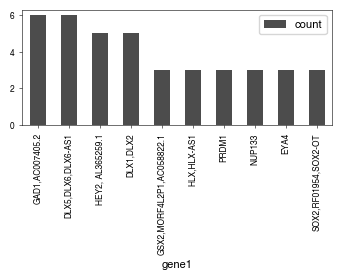

In [257]:
en_thr = pca_load['PC1'].quantile(0.15)
pca_load_pc1 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc1['noex1'] = pca_load_pc1['gene1'].map(hand_noex_map)
pca_load_pc1['noex2'] = pca_load_pc1['gene2'].map(hand_noex_map)
pca_load_pc1 = pca_load_pc1.loc[(pca_load_pc1['PC1'] < en_thr) & 
                                 pca_load_pc1['noex2'] & 
                                (pca_load_pc1['noex1'] != True)]
pca_load_cnts = pca_load_pc1['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2].plot(kind='bar', figsize=[4, 1.5], color='k', alpha=0.7)

# plt.savefig("dot_count_pc1_EN.pdf", bbox_inches='tight')

In [258]:
flank = 10 * res
nproc = 20

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc1.loc[pca_load_pc1['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

GAD1,AC007405.2 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GAD1,AC007405.2 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_2T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_3T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_infant


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_adult


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_2T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_3T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_infant


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_adult


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


HEY2, AL365259.1 EN_2T


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


HEY2, AL365259.1 EN_3T


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


HEY2, AL365259.1 EN_infant


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


HEY2, AL365259.1 EN_adult


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


HEY2, AL365259.1 IN_2T


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


HEY2, AL365259.1 IN_3T


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


HEY2, AL365259.1 IN_infant


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


HEY2, AL365259.1 IN_adult


INFO:coolpuppy:('chr6', 'chr6'): 5
INFO:coolpuppy:Total number of piled up windows: 5


DLX1,DLX2 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


DLX1,DLX2 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


DLX1,DLX2 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


DLX1,DLX2 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


DLX1,DLX2 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


DLX1,DLX2 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


DLX1,DLX2 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


DLX1,DLX2 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 EN_2T


INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:Total number of piled up windows: 3


GSX2,MORF4L2P1,AC058822.1 EN_3T


INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:Total number of piled up windows: 3


GSX2,MORF4L2P1,AC058822.1 EN_infant


INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:Total number of piled up windows: 3


GSX2,MORF4L2P1,AC058822.1 EN_adult


INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:Total number of piled up windows: 3


GSX2,MORF4L2P1,AC058822.1 IN_2T


INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:Total number of piled up windows: 3


GSX2,MORF4L2P1,AC058822.1 IN_3T


INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:Total number of piled up windows: 3


GSX2,MORF4L2P1,AC058822.1 IN_infant


INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:Total number of piled up windows: 3


GSX2,MORF4L2P1,AC058822.1 IN_adult


INFO:coolpuppy:('chr4', 'chr4'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HLX,HLX-AS1 EN_2T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HLX,HLX-AS1 EN_3T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HLX,HLX-AS1 EN_infant


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HLX,HLX-AS1 EN_adult


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HLX,HLX-AS1 IN_2T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HLX,HLX-AS1 IN_3T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HLX,HLX-AS1 IN_infant


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HLX,HLX-AS1 IN_adult


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 EN_2T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 EN_3T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 EN_infant


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 EN_adult


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 IN_2T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 IN_3T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 IN_infant


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PRDM1 IN_adult


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NUP133 EN_2T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NUP133 EN_3T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NUP133 EN_infant


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NUP133 EN_adult


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NUP133 IN_2T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NUP133 IN_3T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NUP133 IN_infant


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NUP133 IN_adult


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


EYA4 EN_2T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


EYA4 EN_3T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


EYA4 EN_infant


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


EYA4 EN_adult


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


EYA4 IN_2T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


EYA4 IN_3T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


EYA4 IN_infant


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


EYA4 IN_adult


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT EN_2T


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT EN_3T


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT EN_infant


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT EN_adult


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT IN_2T


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT IN_3T


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT IN_infant


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT IN_adult


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1

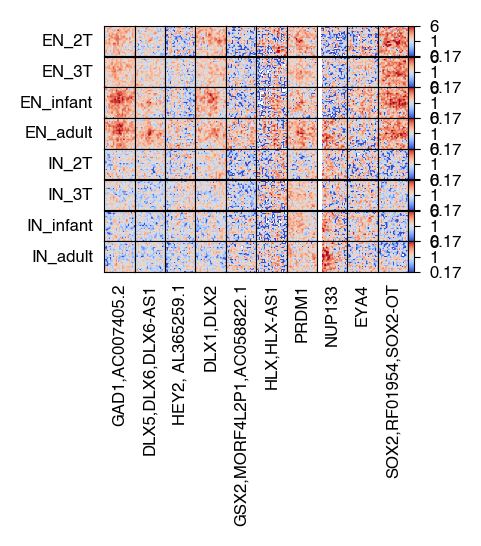

In [259]:
plot_av_dot_pca(stack, 6, dpi=200)
# plt.savefig("av_dot_pc1_IN.pdf", bbox_inches='tight')

<Axes: xlabel='gene1'>

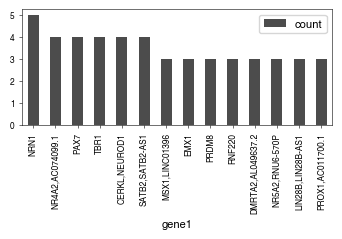

In [254]:
in_thr = pca_load['PC1'].quantile(0.85)
pca_load_pc1 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc1['noex1'] = pca_load_pc1['gene1'].map(hand_noex_map)
pca_load_pc1['noex2'] = pca_load_pc1['gene2'].map(hand_noex_map)
pca_load_pc1 = pca_load_pc1.loc[(pca_load_pc1['PC1'] > in_thr) & 
                                 pca_load_pc1['noex2'] & 
                                (pca_load_pc1['noex1'] != True)]
pca_load_cnts = pca_load_pc1['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2].plot(kind='bar', figsize=[4, 1.5], color='k', alpha=0.7)

# plt.savefig("dot_count_pc1_IN.pdf", bbox_inches='tight')

In [ ]:
flank = 10 * res
nproc = 20

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc1.loc[pca_load_pc1['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

SOX11 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_2T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_3T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_infant


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_adult


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_2T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_3T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_infant


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_adult


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GSX2,MORF4L2P1,AC058822.1 EN_2T


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 EN_3T


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 EN_infant


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 EN_adult


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 IN_2T


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 IN_3T


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 IN_infant


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 IN_adult


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 EN_2T


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 EN_3T


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 EN_infant


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 EN_adult


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 IN_2T


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 IN_3T


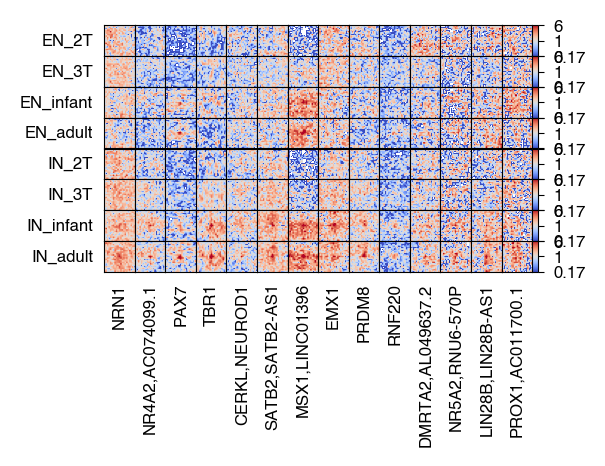

In [256]:
plot_av_dot_pca(stack, 6, dpi=200)
# plt.savefig("av_dot_pc1_IN.pdf", bbox_inches='tight')

## PC2

-0.01502477256997164 0.026338646703712963


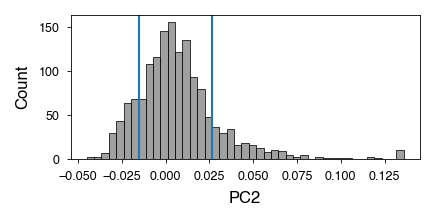

In [263]:
plt.figure(dpi=150, figsize=[3, 1.25])
sns.histplot(pca_load['PC2'], color='grey')
plt.axvline(pca_load['PC2'].quantile(0.15), linewidth=1)
plt.axvline(pca_load['PC2'].quantile(0.85), linewidth=1)
# plt.savefig("heffel.pc2_loadings_hist.pdf", bbox_inches='tight')
print(
    pca_load['PC2'].quantile(0.15),
    pca_load['PC2'].quantile(0.85),
)

<Axes: xlabel='gene1'>

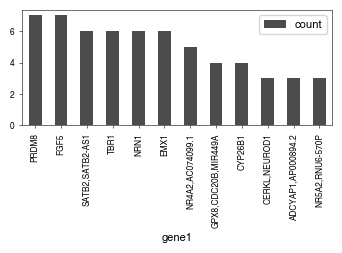

In [277]:
en_thr = pca_load['PC2'].quantile(0.15)
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[(pca_load_pc2['PC2'] < en_thr) & 
                                 pca_load_pc2['noex2'] & 
                                (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2].plot(kind='bar', figsize=[4, 1.5], color='k', alpha=0.7)

# plt.savefig("heffel.dot_count_pc2_IN.pdf", bbox_inches='tight')

In [286]:
hand_noex_map.loc['CERKL,NEUROD1']

False

In [281]:
pca_load_pc2.loc[pca_load_pc2['gene1'] == 'CERKL,NEUROD1']

PC1       PC2       PC3       PC4 chrom1     start1       end1  \
492  0.052635 -0.015730 -0.003158 -0.005348   chr2  181680000  181690000   
424  0.037904 -0.024227 -0.046402  0.037778   chr2  118830000  118840000   
485  0.020988 -0.021966  0.019126  0.016206   chr2  176060000  176170000   

    chrom2     start2       end2          gene1  \
492   chr2  222250000  222318000  CERKL,NEUROD1   
424   chr2  181680000  181690000  CERKL,NEUROD1   
485   chr2  181680000  181690000  CERKL,NEUROD1   

                                                 gene2  \
492                                       PAX3,CCDC140   
424                                      EN1,LINC01956   
485  HOXD1,HOXD2,HOXD3,HOXD4,HOXD8,HOXD9,HOXD10,HOX...   

                                                 genes  noex1 noex2  
492                     CERKL,NEUROD1 <-> PAX3,CCDC140  False  True  
424                    EN1,LINC01956 <-> CERKL,NEUROD1  False  True  
485  HOXD1,HOXD2,HOXD3,HOXD4,HOXD8,HOXD9,HOXD10,HOX...  False  True

In [265]:
flank = 10 * res
nproc = 20

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

PRDM8 EN_2T


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


PRDM8 EN_3T


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


PRDM8 EN_infant


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


PRDM8 EN_adult


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


PRDM8 IN_2T


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


PRDM8 IN_3T


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


PRDM8 IN_infant


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


PRDM8 IN_adult


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 EN_2T


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 EN_3T


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 EN_infant


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 EN_adult


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 IN_2T


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 IN_3T


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 IN_infant


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


FGF5 IN_adult


INFO:coolpuppy:('chr4', 'chr4'): 7
INFO:coolpuppy:Total number of piled up windows: 7


SATB2,SATB2-AS1 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SATB2,SATB2-AS1 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SATB2,SATB2-AS1 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SATB2,SATB2-AS1 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SATB2,SATB2-AS1 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SATB2,SATB2-AS1 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SATB2,SATB2-AS1 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SATB2,SATB2-AS1 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


TBR1 EN_2T


INFO:coolpuppy:Total number of piled up windows: 6


TBR1 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


TBR1 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


TBR1 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


TBR1 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


TBR1 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


TBR1 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


TBR1 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 EN_2T


INFO:coolpuppy:('chr6', 'chr6'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 EN_3T


INFO:coolpuppy:('chr6', 'chr6'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 EN_infant


INFO:coolpuppy:('chr6', 'chr6'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 EN_adult


INFO:coolpuppy:('chr6', 'chr6'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 IN_2T


INFO:coolpuppy:('chr6', 'chr6'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 IN_3T


INFO:coolpuppy:('chr6', 'chr6'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 IN_infant


INFO:coolpuppy:('chr6', 'chr6'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NRN1 IN_adult


INFO:coolpuppy:('chr6', 'chr6'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


EMX1 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


NR4A2,AC074099.1 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NR4A2,AC074099.1 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NR4A2,AC074099.1 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NR4A2,AC074099.1 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NR4A2,AC074099.1 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NR4A2,AC074099.1 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NR4A2,AC074099.1 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


NR4A2,AC074099.1 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GPX8,CDC20B,MIR449A EN_2T


INFO:coolpuppy:('chr5', 'chr5'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GPX8,CDC20B,MIR449A EN_3T


INFO:coolpuppy:('chr5', 'chr5'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GPX8,CDC20B,MIR449A EN_infant


INFO:coolpuppy:('chr5', 'chr5'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GPX8,CDC20B,MIR449A EN_adult


INFO:coolpuppy:('chr5', 'chr5'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GPX8,CDC20B,MIR449A IN_2T


INFO:coolpuppy:('chr5', 'chr5'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GPX8,CDC20B,MIR449A IN_3T


INFO:coolpuppy:('chr5', 'chr5'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GPX8,CDC20B,MIR449A IN_infant


INFO:coolpuppy:('chr5', 'chr5'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GPX8,CDC20B,MIR449A IN_adult


INFO:coolpuppy:('chr5', 'chr5'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CYP26B1 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


CERKL,NEUROD1 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CERKL,NEUROD1 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CERKL,NEUROD1 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CERKL,NEUROD1 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CERKL,NEUROD1 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CERKL,NEUROD1 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CERKL,NEUROD1 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CERKL,NEUROD1 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


ADCYAP1,AP000894.2 EN_2T


INFO:coolpuppy:Total number of piled up windows: 0


ADCYAP1,AP000894.2 EN_3T


INFO:coolpuppy:Total number of piled up windows: 0


ADCYAP1,AP000894.2 EN_infant


INFO:coolpuppy:Total number of piled up windows: 0


ADCYAP1,AP000894.2 EN_adult


INFO:coolpuppy:Total number of piled up windows: 0


ADCYAP1,AP000894.2 IN_2T


INFO:coolpuppy:Total number of piled up windows: 0


ADCYAP1,AP000894.2 IN_3T


INFO:coolpuppy:Total number of piled up windows: 0


ADCYAP1,AP000894.2 IN_infant


INFO:coolpuppy:Total number of piled up windows: 0


ADCYAP1,AP000894.2 IN_adult


INFO:coolpuppy:Total number of piled up windows: 0


NR5A2,RNU6-570P EN_2T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NR5A2,RNU6-570P EN_3T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NR5A2,RNU6-570P EN_infant


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NR5A2,RNU6-570P EN_adult


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NR5A2,RNU6-570P IN_2T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NR5A2,RNU6-570P IN_3T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NR5A2,RNU6-570P IN_infant


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


NR5A2,RNU6-570P IN_adult


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1][grp2]['data'].to_list()), axis=0)
/tmp/ipykernel_3747925/654606212.py:79: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(np.array(pup[grp1

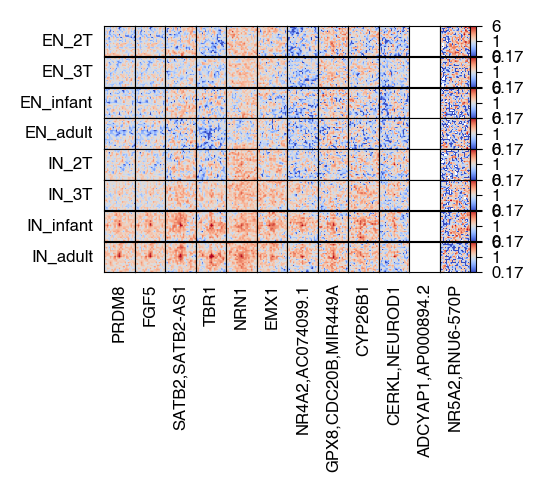

In [267]:
plot_av_dot_pca(stack, 6, dpi=200)
# plt.savefig("heffel.av_dot_pc2_IN.pdf", bbox_inches='tight')

<Axes: xlabel='gene1'>

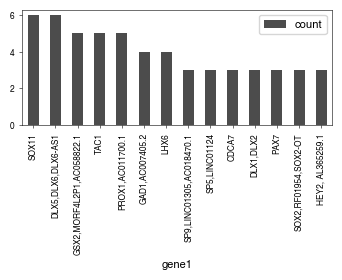

In [273]:
in_thr = pca_load['PC2'].quantile(0.85)
pca_load_pc2 = pd.concat([pca_load, pca_load.rename(columns={'gene1': 'gene2', 'gene2': 'gene1'})])
pca_load_pc2['noex1'] = pca_load_pc2['gene1'].map(hand_noex_map)
pca_load_pc2['noex2'] = pca_load_pc2['gene2'].map(hand_noex_map)
pca_load_pc2 = pca_load_pc2.loc[(pca_load_pc2['PC2'] > in_thr) & 
                                 pca_load_pc2['noex2'] & 
                                (pca_load_pc2['noex1'] != True)]
pca_load_cnts = pca_load_pc2['gene1'].value_counts().to_frame()
pca_load_cnts.loc[pca_load_cnts['count'] > 2].plot(kind='bar', figsize=[4, 1.5], color='k', alpha=0.7)

# plt.savefig("heffel.dot_count_pc2_EN.pdf", bbox_inches='tight')

In [274]:
flank = 10 * res
nproc = 20

genes = pca_load_cnts.loc[pca_load_cnts['count'] > 2].index
stack = {grp: {} for grp in pl_grps}

for gene in genes:
    gene_df = pca_load_pc2.loc[pca_load_pc2['gene1'] == gene]
    for grp in pl_grps:
        print(gene, grp)
        stack[grp][gene] = coolpup.pileup(
            pl_clrs[grp], 
            gene_df, 
            features_format='bedpe',
            view_df=hg38_chromsizes_view, 
            expected_df=pl_cvd[grp], 
            flank=flank,
            nproc=nproc
        )

SOX11 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


SOX11 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_2T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_3T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_infant


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 EN_adult


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_2T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_3T


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_infant


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


DLX5,DLX6,DLX6-AS1 IN_adult


INFO:coolpuppy:('chr7', 'chr7'): 6
INFO:coolpuppy:Total number of piled up windows: 6


GSX2,MORF4L2P1,AC058822.1 EN_2T


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 EN_3T


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 EN_infant


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 EN_adult


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 IN_2T


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 IN_3T


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 IN_infant


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GSX2,MORF4L2P1,AC058822.1 IN_adult


INFO:coolpuppy:('chr4', 'chr4'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 EN_2T


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 EN_3T


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 EN_infant


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 EN_adult


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 IN_2T


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 IN_3T


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 IN_infant


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


TAC1 IN_adult


INFO:coolpuppy:('chr7', 'chr7'): 5
INFO:coolpuppy:Total number of piled up windows: 5


PROX1,AC011700.1 EN_2T


INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:Total number of piled up windows: 5


PROX1,AC011700.1 EN_3T


INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:Total number of piled up windows: 5


PROX1,AC011700.1 EN_infant


INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:Total number of piled up windows: 5


PROX1,AC011700.1 EN_adult


INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:Total number of piled up windows: 5


PROX1,AC011700.1 IN_2T


INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:Total number of piled up windows: 5


PROX1,AC011700.1 IN_3T


INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:Total number of piled up windows: 5


PROX1,AC011700.1 IN_infant


INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:Total number of piled up windows: 5


PROX1,AC011700.1 IN_adult


INFO:coolpuppy:('chr1', 'chr1'): 5
INFO:coolpuppy:Total number of piled up windows: 5


GAD1,AC007405.2 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GAD1,AC007405.2 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GAD1,AC007405.2 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GAD1,AC007405.2 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GAD1,AC007405.2 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GAD1,AC007405.2 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GAD1,AC007405.2 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


GAD1,AC007405.2 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LHX6 EN_2T


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LHX6 EN_3T


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LHX6 EN_infant


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LHX6 EN_adult


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LHX6 IN_2T


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LHX6 IN_3T


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LHX6 IN_infant


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:Total number of piled up windows: 4


LHX6 IN_adult


INFO:coolpuppy:('chr9', 'chr9'): 4
INFO:coolpuppy:Total number of piled up windows: 4


SP9,LINC01305,AC018470.1 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP9,LINC01305,AC018470.1 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP9,LINC01305,AC018470.1 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP9,LINC01305,AC018470.1 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP9,LINC01305,AC018470.1 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP9,LINC01305,AC018470.1 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP9,LINC01305,AC018470.1 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP9,LINC01305,AC018470.1 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP5,LINC01124 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP5,LINC01124 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP5,LINC01124 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP5,LINC01124 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP5,LINC01124 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP5,LINC01124 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP5,LINC01124 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SP5,LINC01124 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CDCA7 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CDCA7 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CDCA7 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CDCA7 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CDCA7 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CDCA7 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CDCA7 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


CDCA7 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


DLX1,DLX2 EN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


DLX1,DLX2 EN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


DLX1,DLX2 EN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


DLX1,DLX2 EN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


DLX1,DLX2 IN_2T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


DLX1,DLX2 IN_3T


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


DLX1,DLX2 IN_infant


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


DLX1,DLX2 IN_adult


INFO:coolpuppy:('chr2', 'chr2'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PAX7 EN_2T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PAX7 EN_3T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PAX7 EN_infant


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PAX7 EN_adult


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PAX7 IN_2T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PAX7 IN_3T


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PAX7 IN_infant


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


PAX7 IN_adult


INFO:coolpuppy:('chr1', 'chr1'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT EN_2T


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT EN_3T


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT EN_infant


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT EN_adult


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT IN_2T


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT IN_3T


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT IN_infant


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


SOX2,RF01954,SOX2-OT IN_adult


INFO:coolpuppy:('chr3', 'chr3'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HEY2, AL365259.1 EN_2T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HEY2, AL365259.1 EN_3T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HEY2, AL365259.1 EN_infant


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HEY2, AL365259.1 EN_adult


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HEY2, AL365259.1 IN_2T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HEY2, AL365259.1 IN_3T


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HEY2, AL365259.1 IN_infant


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


HEY2, AL365259.1 IN_adult


INFO:coolpuppy:('chr6', 'chr6'): 3
INFO:coolpuppy:Total number of piled up windows: 3


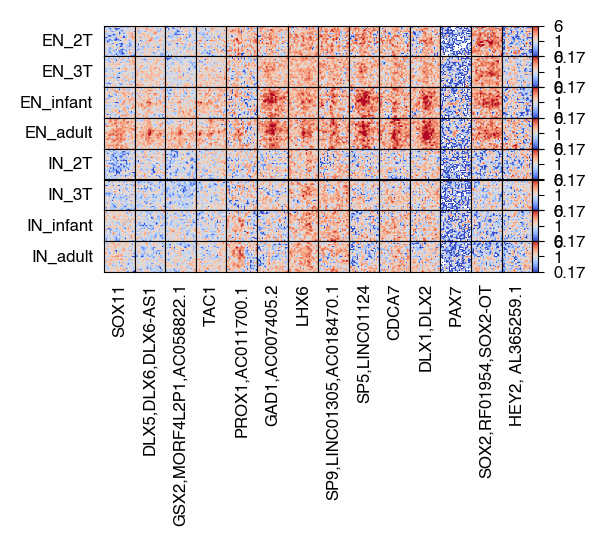

In [276]:
plot_av_dot_pca(stack, 6, dpi=200)
# plt.savefig("heffel.av_dot_pc2_EN.pdf", bbox_inches='tight')